In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from lazypredict import Supervised
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn
import xgboost
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer

Učitavanje podataka - Nivo vlažnosti, Temperatura, Period u danu, Da li je bogomoljka uspešno namamila svoj plen, Vreme utrošeno na lov, Veličina plena, Da li je bogomoljka lovila iz zasede, Da li su bili prisutni drugi predatori, Da li se bogomoljka takmičila za plen, Da li je bogomoljka bila uspešna u lovu
Odluka: Radiće se klasifikacija za Hunting Success, model na osnovu zadatih parametara treba da predvidi da li je lov bio uspešan ili ne

In [3]:
dataset = pd.read_csv('../data/data.csv')

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Prikaz osnovnih informacija

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      300000 non-null  float64
 1   Temperature         300000 non-null  float64
 2   Time of Day         300000 non-null  object 
 3   Luring Success      300000 non-null  bool   
 4   Time Spent Hunting  300000 non-null  float64
 5   Prey Size           300000 non-null  float64
 6   Ambush              300000 non-null  bool   
 7   Food Availability   269788 non-null  object 
 8   Predator Presence   270292 non-null  object 
 9   Is Competition      269881 non-null  object 
 10  Hunting Success     300000 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


Prikaz sumirane statistike

In [5]:
dataset.describe()

,Humidity Level,Temperature,Time Spent Hunting,Prey Size,Hunting Success
count,300000.00,300000.00,300000.00,300000.00,300000.00
mean,0.60,27.50,2.73,5.66,0.55
std,0.17,4.33,1.41,2.82,0.50
min,0.30,20.00,0.40,1.00,0.00
25%,0.45,23.75,1.55,3.31,0.00
50%,0.60,27.49,2.69,5.59,1.00
75%,0.75,31.25,3.84,7.88,1.00
max,0.90,35.00,10.19,20.97,1.00


### Analiza raspodele target varijable

In [6]:
hunting_success_dist = dataset['Hunting Success'].value_counts()
print("Raspodela Hunting Success:")
print(hunting_success_dist)
print(f"\nProcenat: {hunting_success_dist / len(dataset) * 100}")

Raspodela Hunting Success:
Hunting Success
1    164957
0    135043
Name: count, dtype: int64

Procenat: Hunting Success
1   54.99
0   45.01
Name: count, dtype: float64


Zapažanje: Dataset je balansiran - obe klase su približno jednako zastupljene.

Provera koliko duplikata postoji u setu podataka

In [7]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')

Broj duplikata: 0


Zapažanja: kolone 7, 8 i 9 su tipa object, iako u .csv-u imaju vrednosti TRUE i FALSE. 
Pretpostavka: Fale podaci u nekim redovima za ove vrednosti.
Prikazan broj praznih vrednosti po kolonama:

In [8]:
dataset.isnull().sum()

Humidity Level            0
Temperature               0
Time of Day               0
Luring Success            0
Time Spent Hunting        0
Prey Size                 0
Ambush                    0
Food Availability     30212
Predator Presence     29708
Is Competition        30119
Hunting Success           0
dtype: int64

Raspodela broja redova prema broju nedostajućih vrednosti:

In [9]:
dataset.isnull().sum(axis=1).value_counts()

0    218592
1     73107
2      7971
3       330
Name: count, dtype: int64

Procenat broja redova prema broju nedostajućih vrednosti - tabela

In [10]:
raspodela = dataset.isnull().sum(axis=1).value_counts().sort_index()
ukupan_broj_redova = len(dataset)

tabela = pd.DataFrame({
    'Broj nedostajućih vrednosti': raspodela.index,
    'Broj redova': raspodela.values,
    'Procenat (%)': (raspodela.values / ukupan_broj_redova * 100).round(2)
})

tabela


,Broj nedostajućih vrednosti,Broj redova,Procenat (%)
0,0,218592,72.86
1,1,73107,24.37
2,2,7971,2.66
3,3,330,0.11


Zapažanje: Većina redova sa praznim vrednostima ima samo jednu nedefinisanu vrednost.
Može se uraditi: Procenat redova kojima fali više od jedne vrednosti je jako mali(ispod 5%) i njihovo brisanje neće značajno uticati na ishod.
Procenat redova kojima nedostaje jedna vrednost predstavlja veliki deo dataseta i treba ih sačuvati za analizu. Prazne vrednosti se mogu zameniti validnim vrednostima na sledeće načine: 
1. Dopisivanjem FALSE u svako prazno polje - Može iskriviti odnos TRUE/FALSE
2. Probabilistička imputacija - Pronalaženje odnosa vrednosti TRUE/FALSE i popunjavanje dataset-a tako da se održi ova razmera - Očuvava se odnos TRUE/FALSE
3. Model based imputacija - Treniranje modela za popunjavanje vrednosti koje fale

Odabrana je opcija 2.

Brisanje redova sa više nedefinisanih vrednosti:

In [11]:
dataset = dataset[dataset.isnull().sum(axis=1) <= 1]
dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  bool   
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  bool   
 7   Food Availability   267110 non-null  object 
 8   Predator Presence   267668 non-null  object 
 9   Is Competition      267212 non-null  object 
 10  Hunting Success     291699 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 22.8+ MB


,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Procentualni odnos vrednosti u kolonama sa True/False podacima

In [12]:
boolean_kolone = []
for kolona in dataset.columns:
    jedinstvene_vrednosti = dataset[kolona].dropna().unique()
    if set(jedinstvene_vrednosti).issubset({0, 1}):
        boolean_kolone.append(kolona)

rezultati = []
for kolona in boolean_kolone:
    ukupno = dataset[kolona].notna().sum()  
    broj_1 = (dataset[kolona] == 1).sum()
    broj_0 = (dataset[kolona] == 0).sum()
    
    proc_1 = (broj_1 / ukupno * 100).round(2) if ukupno > 0 else 0
    proc_0 = (broj_0 / ukupno * 100).round(2) if ukupno > 0 else 0
    
    rezultati.append({
        'Kolona': kolona,
        'Broj vrednosti TRUE/1': broj_1,
        'Broj vrednosti FALSE/0': broj_0,
        'Procenat TRUE/1 (%)': proc_1,
        'Procenat FALSE/0 (%)': proc_0,
        'Ukupno': ukupno
    })

tabela_boolean = pd.DataFrame(rezultati)
tabela_boolean


,Kolona,Broj vrednosti TRUE/1,Broj vrednosti FALSE/0,Procenat TRUE/1 (%),Procenat FALSE/0 (%),Ukupno
0,Luring Success,145980,145719,50.04,49.96,291699
1,Ambush,145594,146105,49.91,50.09,291699
2,Predator Presence,133661,134007,49.94,50.06,267668
3,Is Competition,133349,133863,49.90,50.10,267212
4,Hunting Success,160315,131384,54.96,45.04,291699


Prevođenje vrednosti kolona sa True/False u 1/0; 
Boolean atributi su transformisani u numerički oblik (0/1) kako bi se omogućila primena algoritama mašinskog učenja koji zahtevaju numeričke ulaze.

In [13]:
kolone = ['Predator Presence', 'Is Competition']

for kolona in kolone:
    dataset[kolona] = dataset[kolona].replace(r'(?i)^true$', 1, regex=True).replace(r'(?i)^false$', 0, regex=True)

for kolona in kolone:
    dataset[kolona] = pd.to_numeric(dataset[kolona], errors='coerce').astype('Int64')

Probabilistička imputacija za kolone sa nedostajućim vrednostima

In [14]:
kolone_boolean = ['Predator Presence', 'Is Competition']

for kol in kolone_boolean:
    p_true = dataset[kol].mean()
    
    dataset[kol] = dataset[kol].apply(
        lambda x: 1 if pd.notna(x) and x == 1 
        else (1 if pd.isna(x) and np.random.rand() < p_true else 0)
    )

if dataset['Food Availability'].isna().any():
    distribucija = dataset['Food Availability'].value_counts(normalize=True)
    kategorije = distribucija.index.tolist()
    verovatnoce = distribucija.values.tolist()
    
    nan_indeksi = dataset['Food Availability'].isna()
    
    dataset.loc[nan_indeksi, 'Food Availability'] = np.random.choice(
        kategorije, 
        size=nan_indeksi.sum(),
        p=verovatnoce,
    )

Transformacija bool TRUE/FALSE vrednosti u numeričke 0/1 int64

In [15]:
dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  int64  
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  int64  
 7   Food Availability   291699 non-null  object 
 8   Predator Presence   291699 non-null  int64  
 9   Is Competition      291699 non-null  int64  
 10  Hunting Success     291699 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 26.7+ MB


<b style="background-color: #470047">Zaokruživanje na dve decimale</b> 

In [16]:
num_cols = dataset.select_dtypes(include=['float64']).columns

for col in num_cols:
    dataset[col] = dataset[col].round(2)

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,1,0.81,6.60,0,Low,1,0,0
1,0.66,29.08,Afternoon,0,2.81,5.38,0,Low,0,0,1
2,0.61,25.74,Evening,1,3.79,15.19,1,Low,0,0,1
3,0.37,22.68,Morning,0,4.27,5.06,1,Low,1,0,1
4,0.65,29.20,Afternoon,0,3.84,2.71,0,High,0,0,1


Učitavanje obrađenih podataka
Prikaz numerickih deskriptivnih pokazatelja

In [17]:
desc = dataset.describe().round(2)

variance_row = (desc.loc['std'] ** 2).round(2)
variance_row.name = 'variance'
desc = pd.concat([desc, variance_row.to_frame().T])

iqr_row = (desc.loc['75%'] - desc.loc['25%']).round(2)
iqr_row.name = 'IQR'
desc = pd.concat([desc, iqr_row.to_frame().T])

desc = desc.reindex(['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR'])

desc

,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00
mean,0.60,27.50,0.50,2.73,5.66,0.50,0.50,0.50,0.55
std,0.17,4.33,0.50,1.41,2.82,0.50,0.50,0.50,0.50
variance,0.03,18.75,0.25,1.99,7.95,0.25,0.25,0.25,0.25
min,0.30,20.00,0.00,0.40,1.00,0.00,0.00,0.00,0.00
25%,0.45,23.74,0.00,1.55,3.31,0.00,0.00,0.00,0.00
50%,0.60,27.50,1.00,2.69,5.59,0.00,0.00,0.00,1.00
75%,0.75,31.25,1.00,3.84,7.88,1.00,1.00,1.00,1.00
max,0.90,35.00,1.00,10.19,20.97,1.00,1.00,1.00,1.00
IQR,0.30,7.51,1.00,2.29,4.57,1.00,1.00,1.00,1.00


Histogram

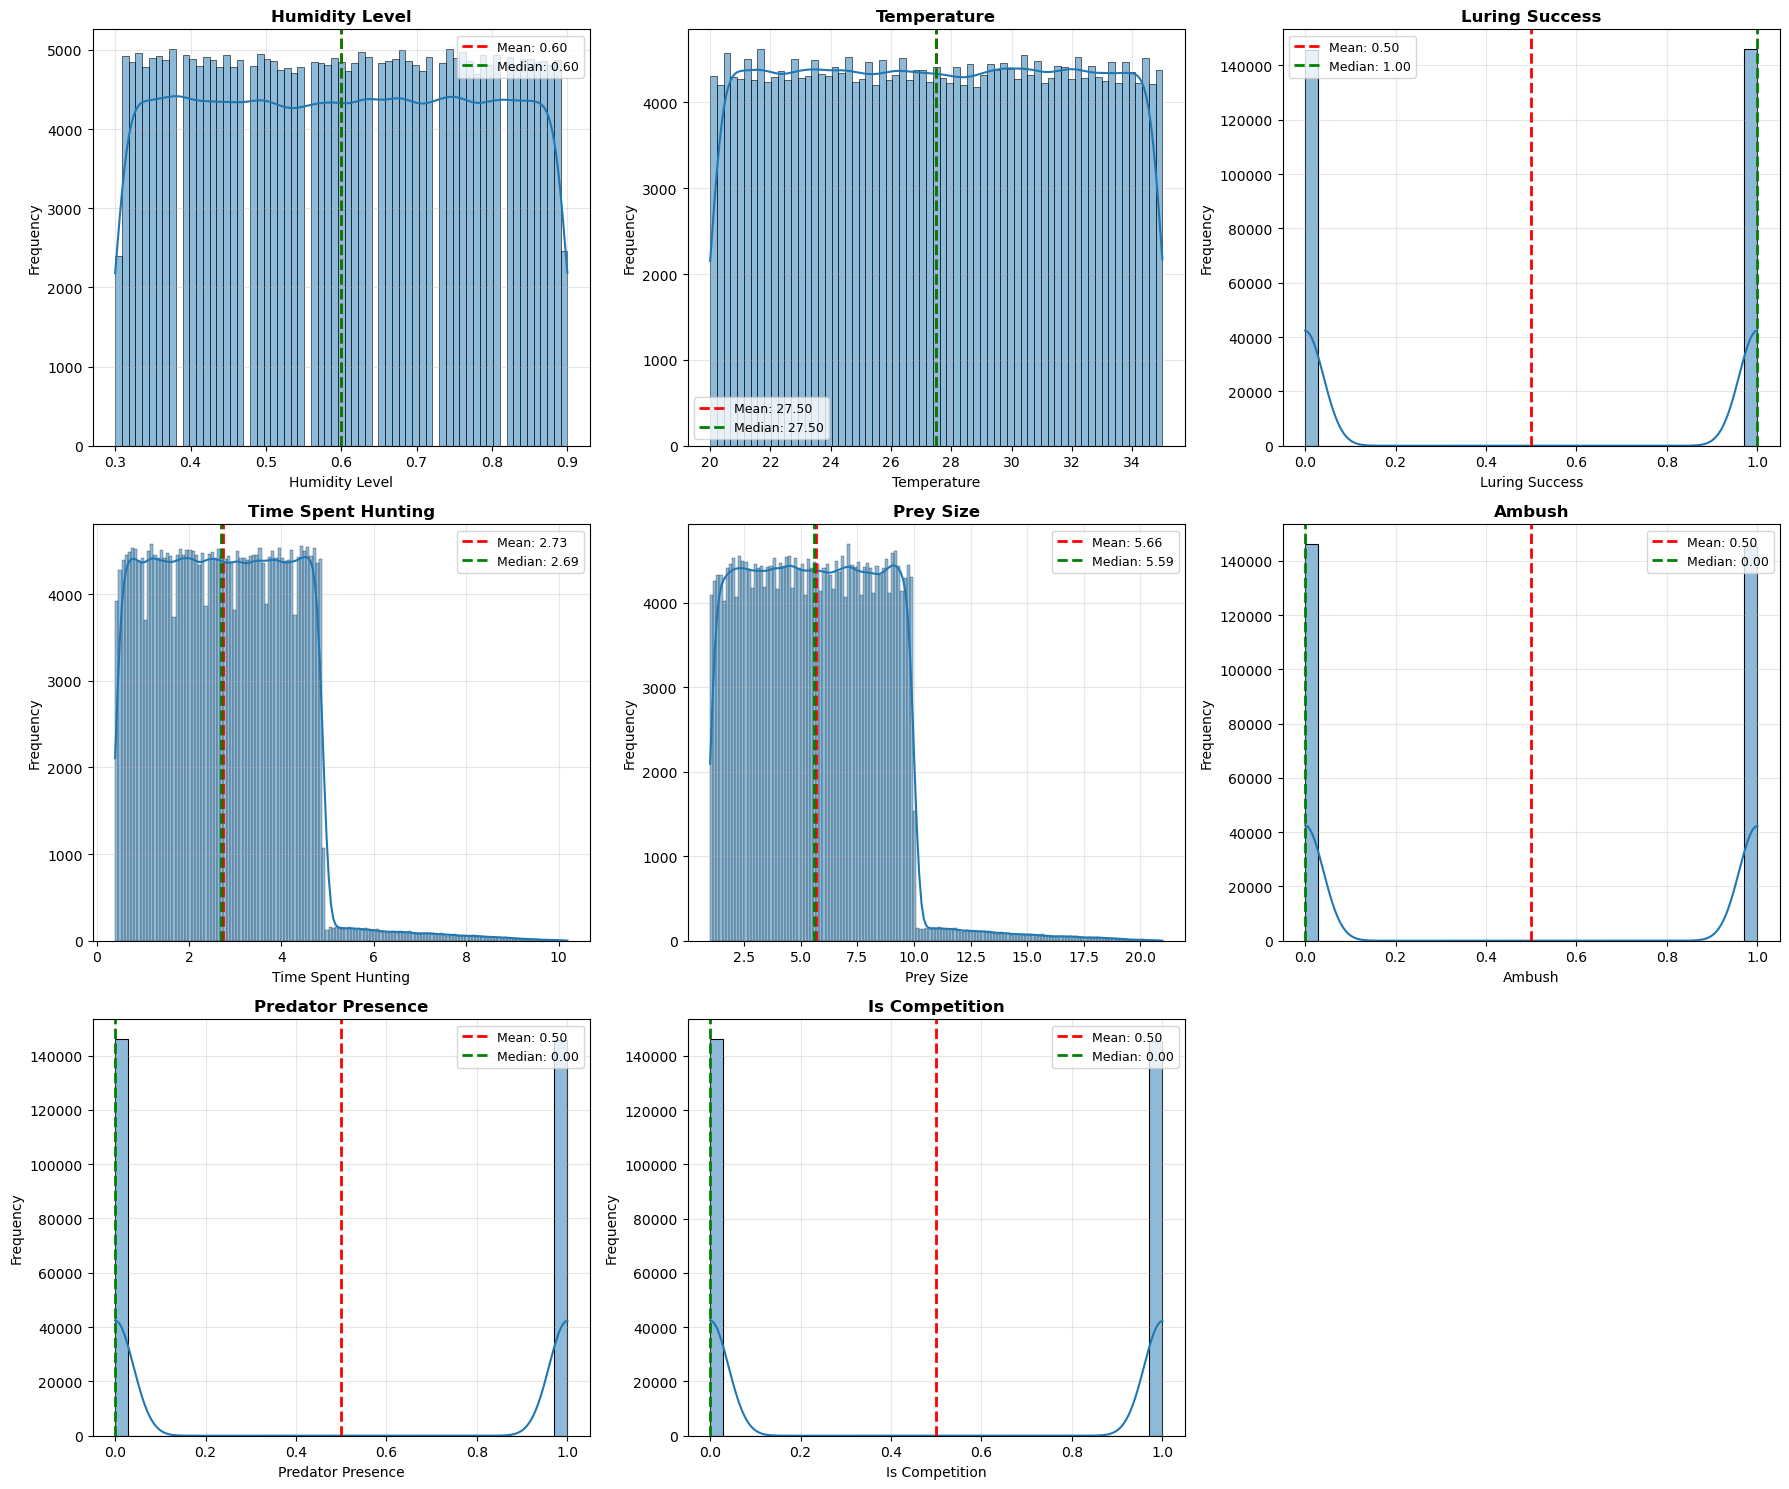

In [18]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Boxplots


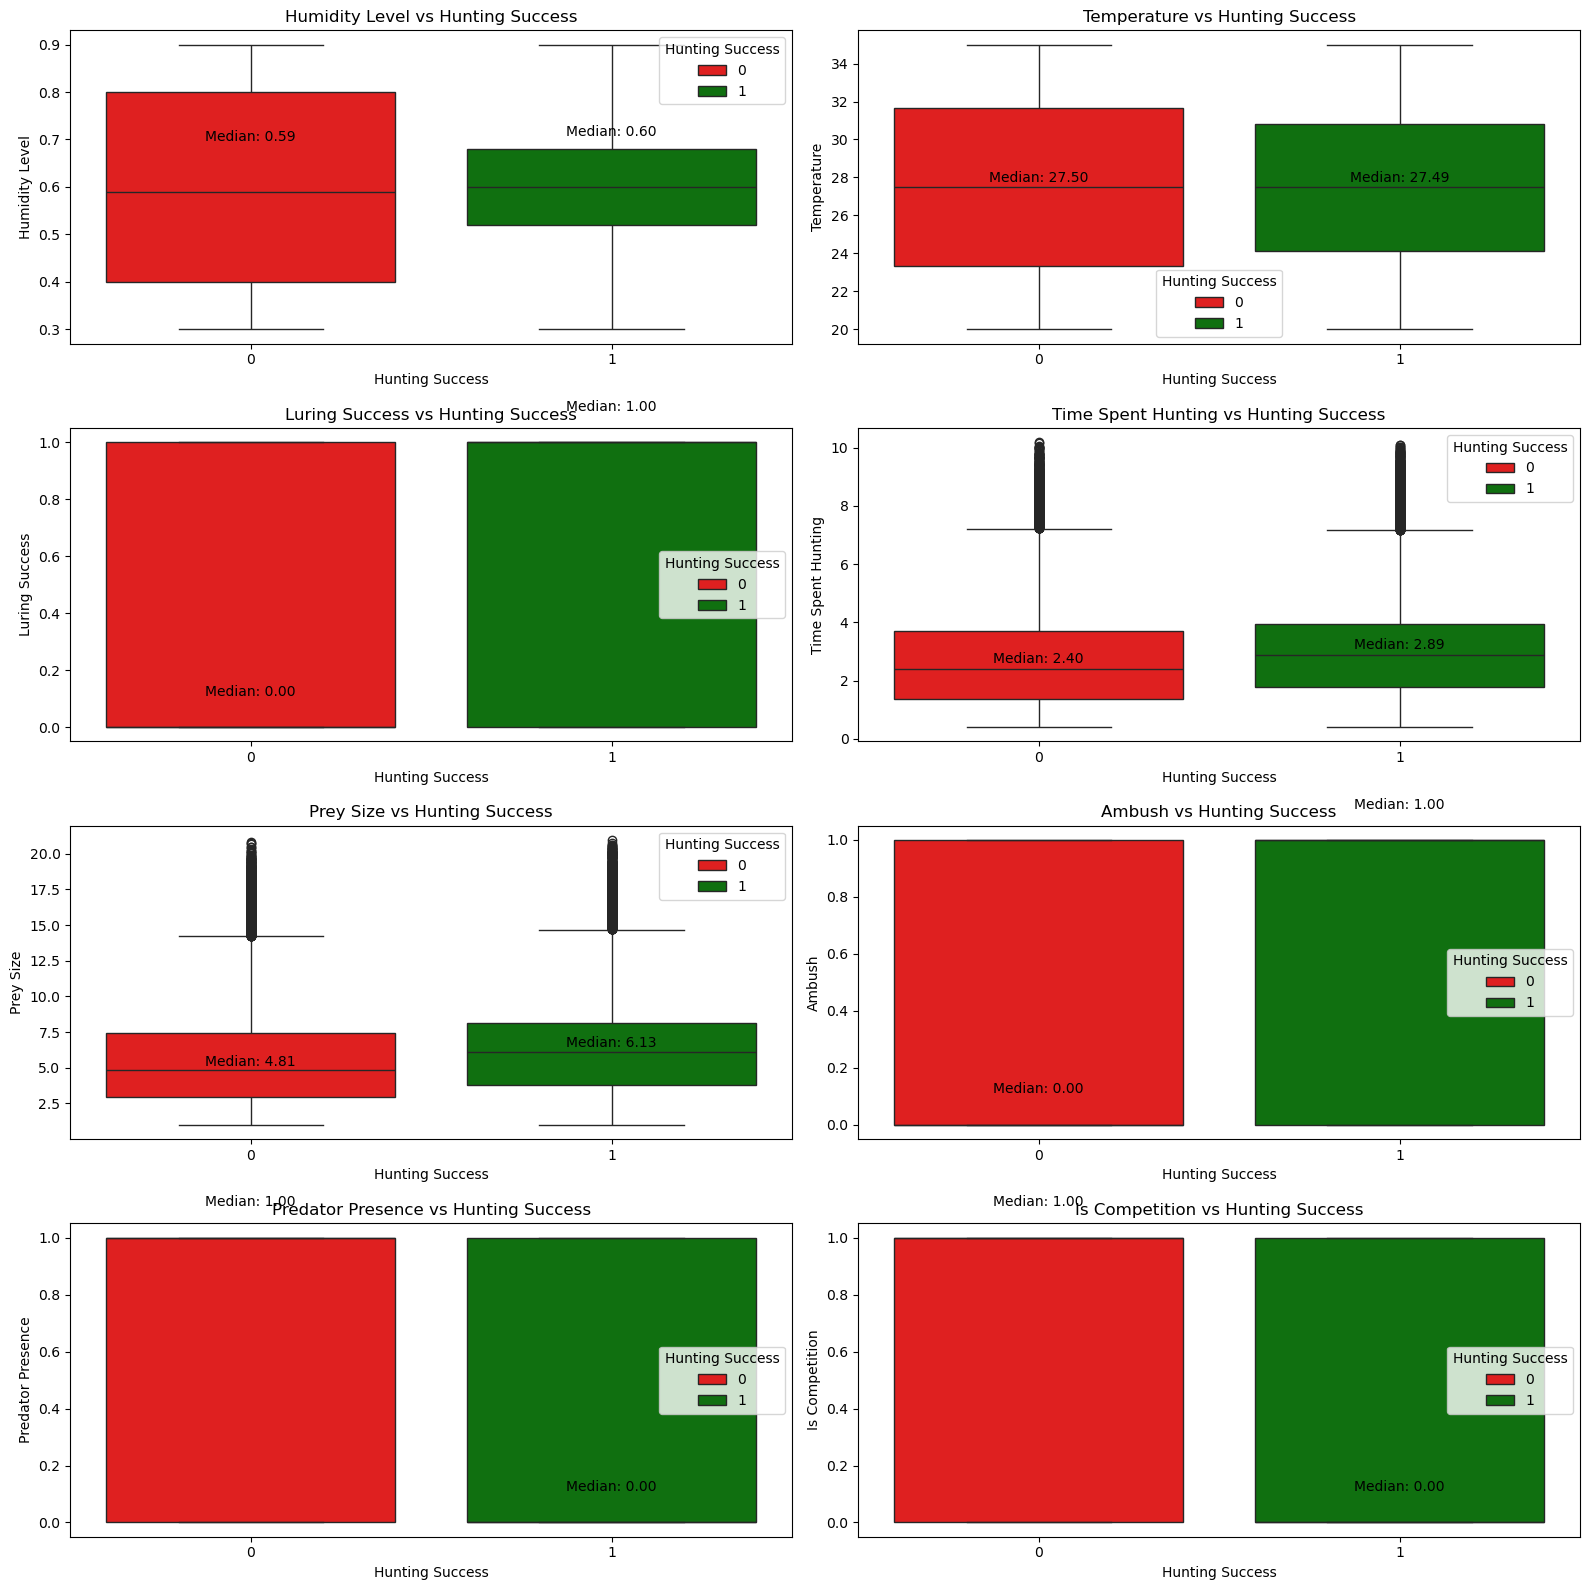

In [19]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
n_cols = 2  
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=ax, palette=('red', 'green'), hue='Hunting Success')
    ax.set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        ax.text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

### Analiza outlier-a
U prethodnoj analizi, primećeno je na osnovu boxplot-a da se outlier-i nalaze samo u kolonama Time Spent Hunting i Prey Size,a na osnovu histograma sa KDE vidi se da je distribucija podataka asimetrična, pa je zbog toga za detekciju broja outlier-a korišena IQR metoda. 

In [20]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')
 
recommendations = []
 
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    outliers_data = dataset[outliers_mask]
    outlier_pct = (len(outliers_data) / len(dataset)) * 100
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = dataset[~outliers_mask]['Hunting Success'].mean()
        impact = abs(outlier_success_rate - normal_success_rate)
    else:
        impact = 0
    recommendations.append({
        'Kolona': col,
        'Broj outlier-a': len(outliers_data),
        'Procenat': f"{outlier_pct:.2f}%",
        'Uticaj na target': f"{impact*100:.2f}%",
    })
 
rec_df = pd.DataFrame(recommendations)
rec_df

,Kolona,Broj outlier-a,Procenat,Uticaj na target
0,Humidity Level,0,0.00%,0.00%
1,Temperature,0,0.00%,0.00%
2,Luring Success,0,0.00%,0.00%
3,Time Spent Hunting,1616,0.55%,3.04%
4,Prey Size,1676,0.57%,7.07%
5,Ambush,0,0.00%,0.00%
6,Predator Presence,0,0.00%,0.00%
7,Is Competition,0,0.00%,0.00%


Korelaciona matrica

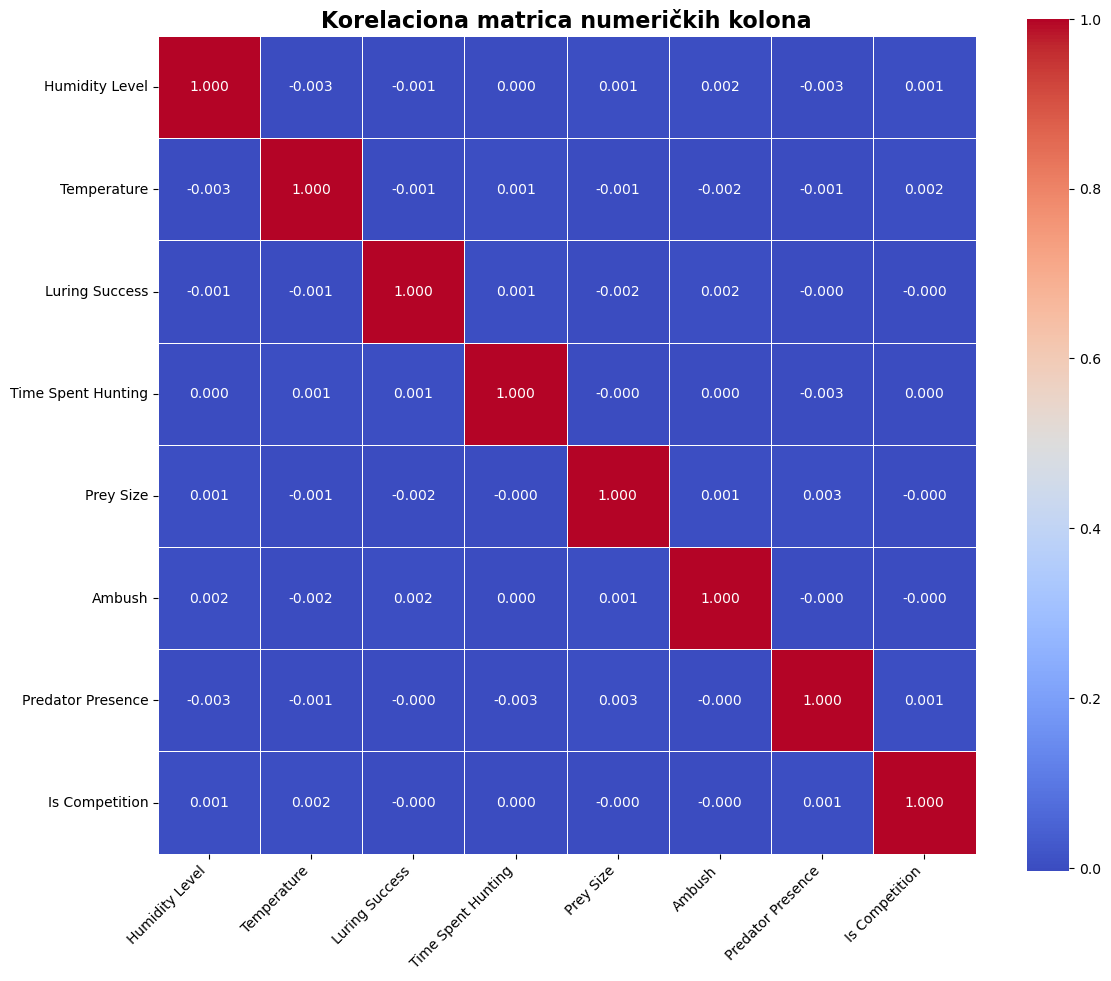

In [21]:
corr_matrix = dataset[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, square=True)
plt.title('Korelaciona matrica numeričkih kolona', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Korelacija feature sa target kolonom

In [22]:
from scipy.stats import pointbiserialr

for col in dataset.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(dataset["Hunting Success"], dataset[col])
    print(f"{col}: {corr:.4f}")

Humidity Level: 0.0013
Temperature: -0.0002
Luring Success: 0.1110
Time Spent Hunting: 0.1098
Prey Size: 0.1366
Ambush: 0.1880
Predator Presence: -0.0708
Is Competition: -0.0723
Hunting Success: 1.0000


Analiza kategorijskih kolona

In [23]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


Value counts za kategorijske kolone


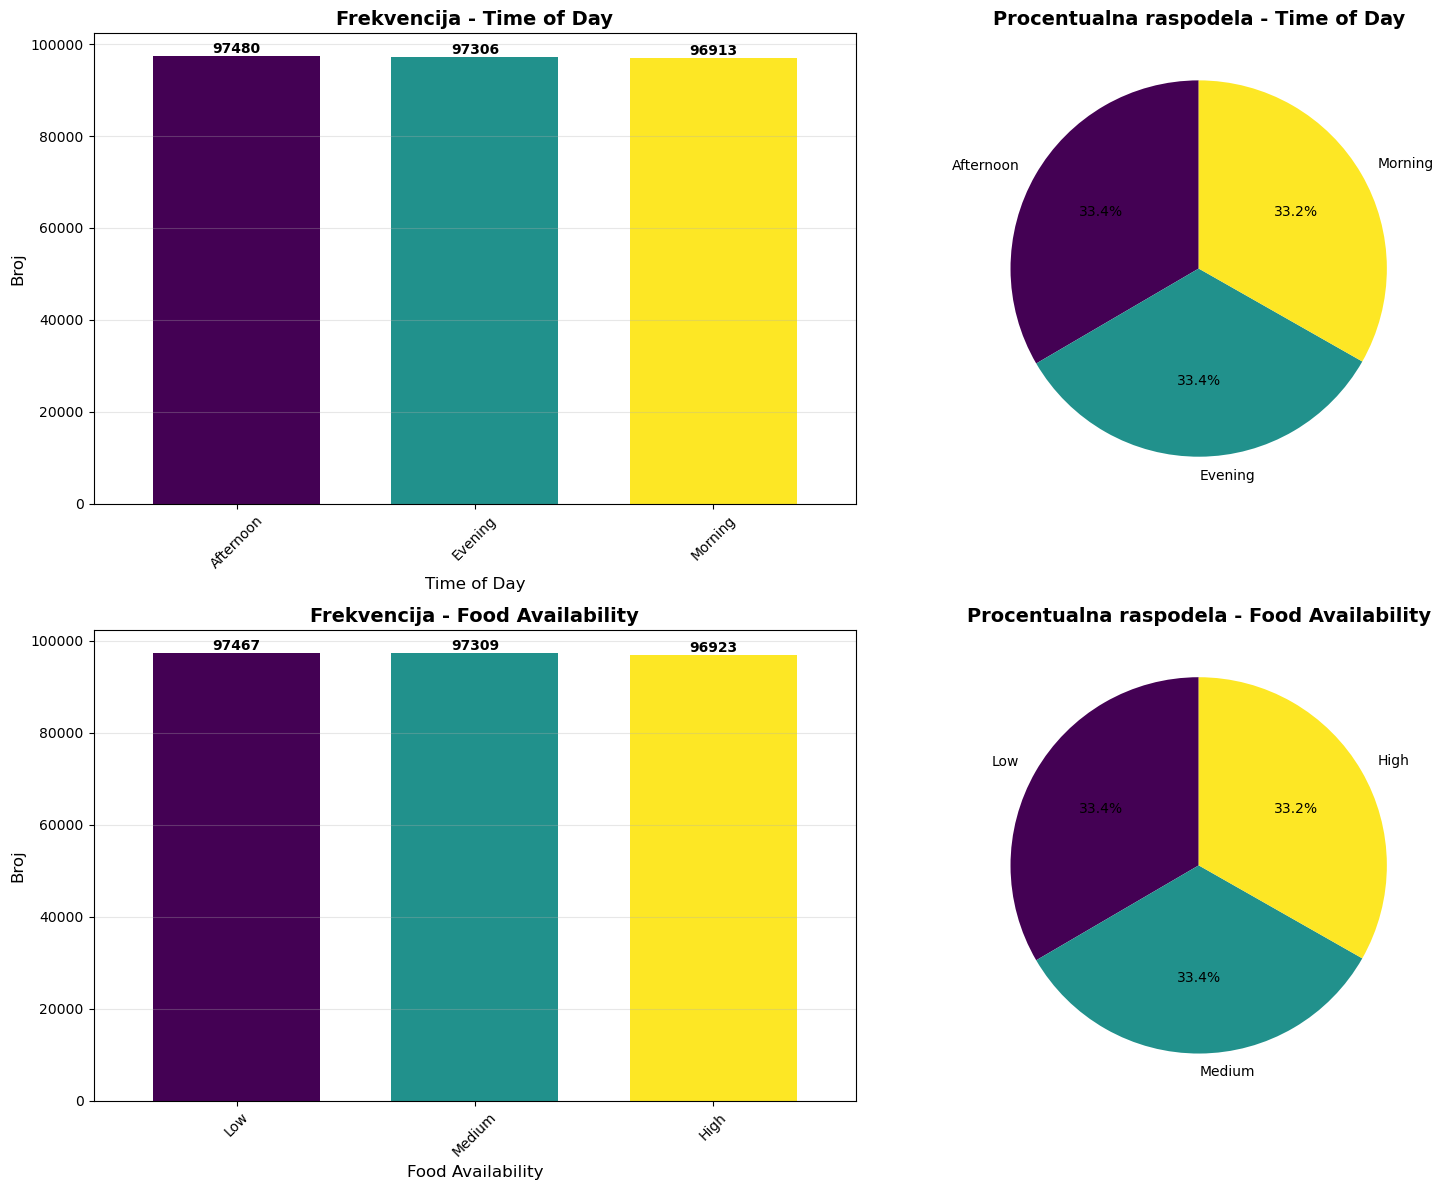

In [24]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = dataset[col].value_counts()
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


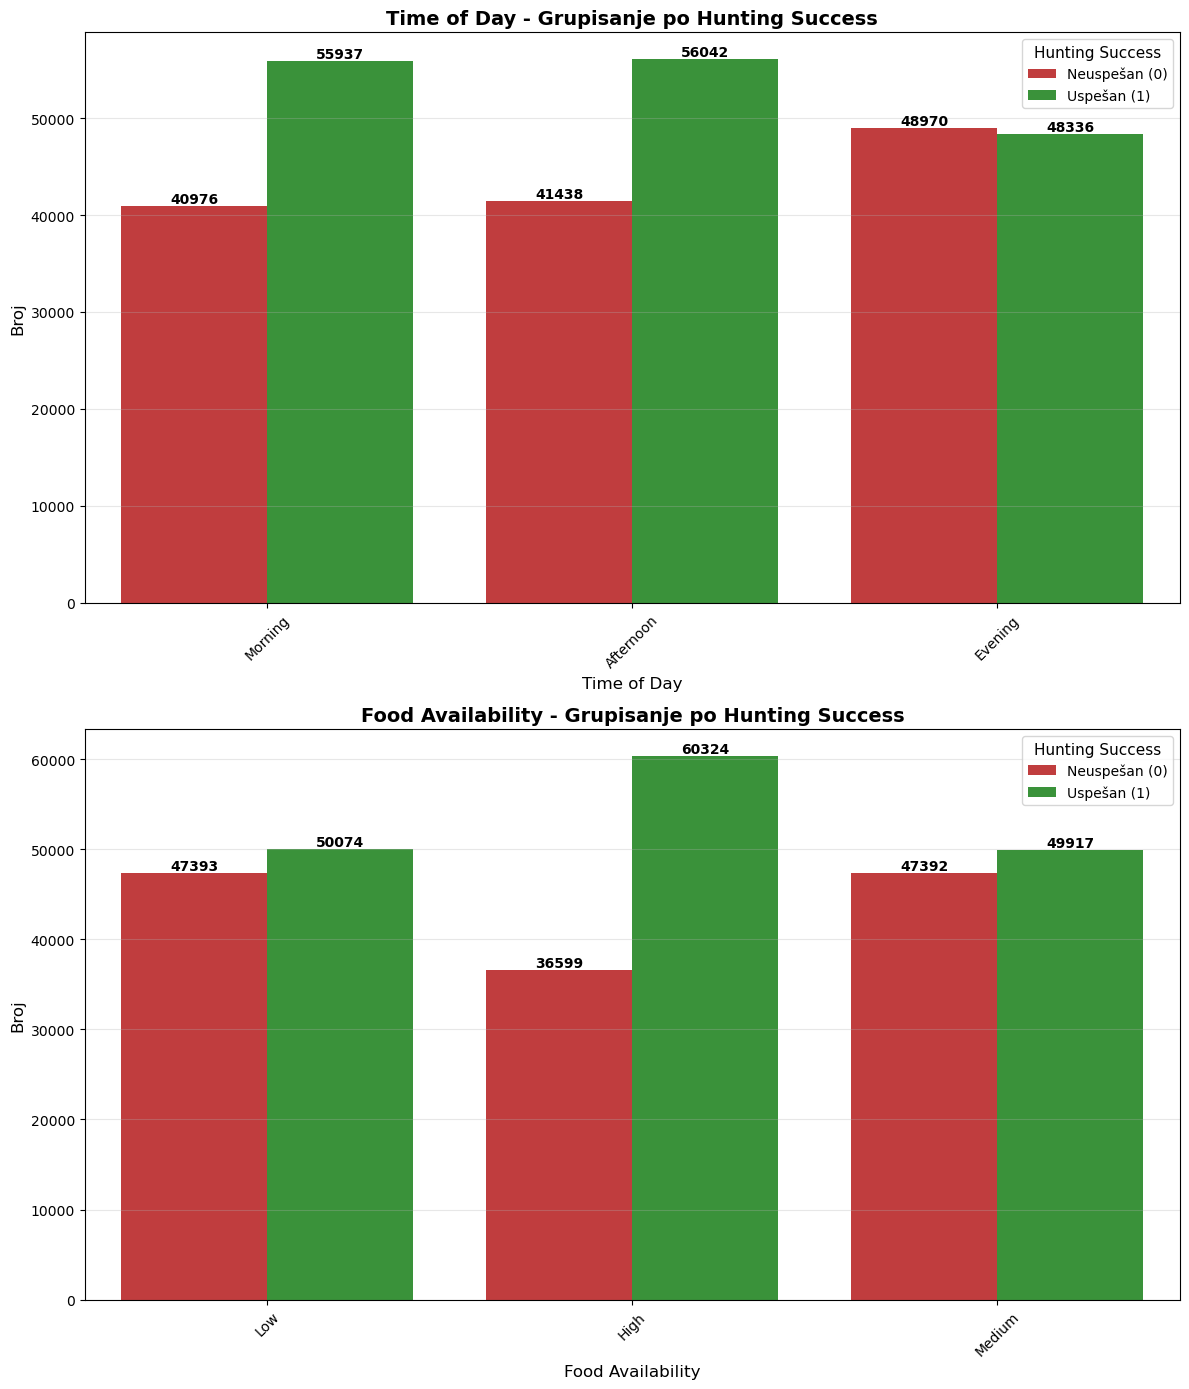

In [25]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


Mode kategorijskih kolona

In [26]:
mode_data = []
 
for col in cat_cols:
    mode_total = dataset[col].mode()
    mode_total_value = mode_total.iloc[0] if len(mode_total) > 0 else None
    mode_total_count = (dataset[col] == mode_total_value).sum() if mode_total_value else 0

    dataset_0 = dataset[dataset['Hunting Success'] == 0]
    mode_0 = dataset_0[col].mode()
    mode_0_value = mode_0.iloc[0] if len(mode_0) > 0 else None
    mode_0_count = (dataset_0[col] == mode_0_value).sum() if mode_0_value else 0

    dataset_1 = dataset[dataset['Hunting Success'] == 1]
    mode_1 = dataset_1[col].mode()
    mode_1_value = mode_1.iloc[0] if len(mode_1) > 0 else None
    mode_1_count = (dataset_1[col] == mode_1_value).sum() if mode_1_value else 0
    mode_data.append({
        'Kategorijska kolona': col,
        'Mode (Ukupno)': mode_total_value,
        'Mode (Hunting Success = 0)': mode_0_value,
        'Mode (Hunting Success = 1)': mode_1_value,
    })
 
mode_df = pd.DataFrame(mode_data)
mode_df

,Kategorijska kolona,Mode (Ukupno),Mode (Hunting Success = 0),Mode (Hunting Success = 1)
0,Time of Day,Afternoon,Evening,Afternoon
1,Food Availability,Low,Low,High


Analiza uticaja outlier-a na target

Detaljna analiza uticaja outlier-a na target varijablu:



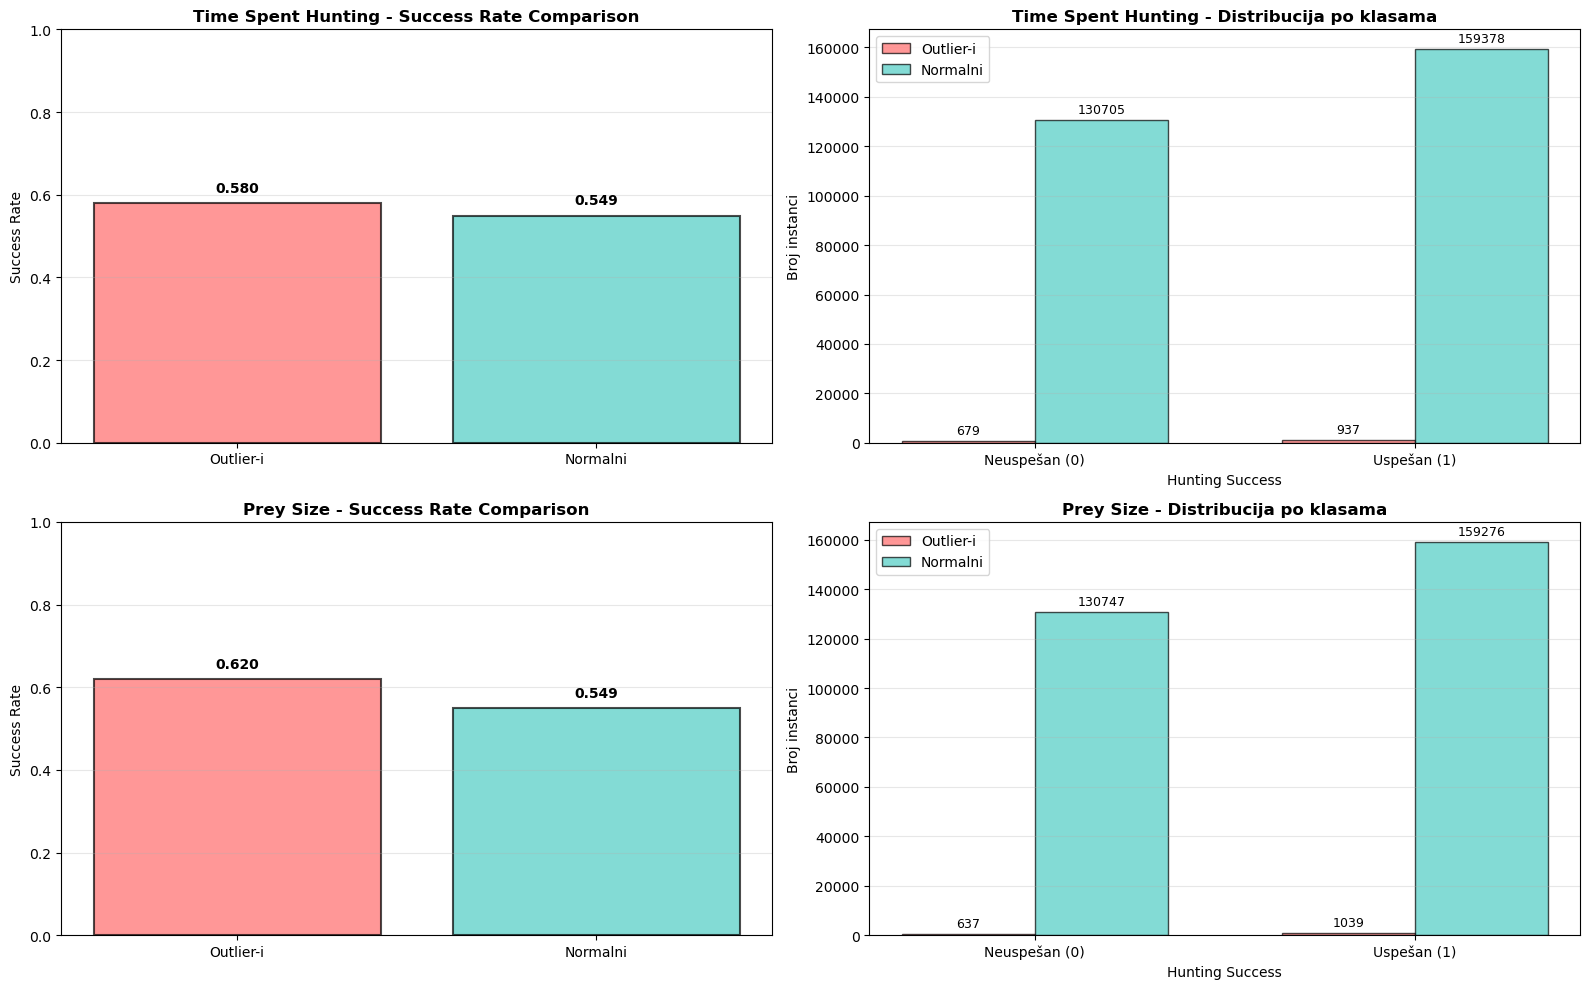

In [27]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

# Detaljna analiza uticaja outlier-a na target varijablu
outlier_analysis = []

for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikacija outlier-a
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    normal_mask = ~outliers_mask
    
    outliers_data = dataset[outliers_mask]
    normal_data = dataset[normal_mask]
    
    if len(outliers_data) > 0:
        # Success rate za outlier-e i normalne vrednosti
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = normal_data['Hunting Success'].mean()
        
        # Distribucija po klasama za outlier-e
        outlier_dist = outliers_data['Hunting Success'].value_counts()
        outlier_dist_pct = outliers_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Distribucija po klasama za normalne vrednosti
        normal_dist = normal_data['Hunting Success'].value_counts()
        normal_dist_pct = normal_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Razlika u success rate-u
        impact = abs(outlier_success_rate - normal_success_rate)
        
        outlier_analysis.append({
            'Kolona': col,
            'Broj outlier-a': len(outliers_data),
            'Procenat outlier-a (%)': f"{(len(outliers_data) / len(dataset) * 100):.2f}%",
            'Success rate (outlier-i)': f"{outlier_success_rate:.4f}",
            'Success rate (normalni)': f"{normal_success_rate:.4f}",
            'Razlika u success rate-u': f"{impact:.4f}",
            'Outlier: Hunting Success = 0': f"{outlier_dist.get(0, 0)} ({outlier_dist_pct.get(0, 0):.2f}%)",
            'Outlier: Hunting Success = 1': f"{outlier_dist.get(1, 0)} ({outlier_dist_pct.get(1, 0):.2f}%)",
            'Normalni: Hunting Success = 0': f"{normal_dist.get(0, 0)} ({normal_dist_pct.get(0, 0):.2f}%)",
            'Normalni: Hunting Success = 1': f"{normal_dist.get(1, 0)} ({normal_dist_pct.get(1, 0):.2f}%)"
        })

outlier_analysis_df = pd.DataFrame(outlier_analysis)
print("Detaljna analiza uticaja outlier-a na target varijablu:\n")
outlier_analysis_df

# Vizualizacija uticaja outlier-a na target
outlier_cols = outlier_analysis_df['Kolona'].tolist()

if len(outlier_cols) > 0:
    fig, axes = plt.subplots(nrows=len(outlier_cols), ncols=2, figsize=(16, 5 * len(outlier_cols)))
    
    if len(outlier_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(outlier_cols):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
        outliers_data = dataset[outliers_mask]
        normal_data = dataset[~outliers_mask]
        
        # Graf 1: Success rate comparison
        categories = ['Outlier-i', 'Normalni']
        success_rates = [
            outliers_data['Hunting Success'].mean(),
            normal_data['Hunting Success'].mean()
        ]
        
        axes[i, 0].bar(categories, success_rates, color=['#ff6b6b', '#4ecdc4'], alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[i, 0].set_title(f'{col} - Success Rate Comparison', fontsize=12, fontweight='bold')
        axes[i, 0].set_ylabel('Success Rate', fontsize=10)
        axes[i, 0].set_ylim([0, 1])
        axes[i, 0].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, rate in enumerate(success_rates):
            axes[i, 0].text(j, rate + 0.02, f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Graf 2: Distribucija po klasama
        outlier_counts = outliers_data['Hunting Success'].value_counts().sort_index()
        normal_counts = normal_data['Hunting Success'].value_counts().sort_index()
        
        x = np.arange(2)
        width = 0.35
        
        outlier_values = [outlier_counts.get(0, 0), outlier_counts.get(1, 0)]
        normal_values = [normal_counts.get(0, 0), normal_counts.get(1, 0)]
        
        axes[i, 1].bar(x - width/2, outlier_values, width, label='Outlier-i', color='#ff6b6b', alpha=0.7, edgecolor='black')
        axes[i, 1].bar(x + width/2, normal_values, width, label='Normalni', color='#4ecdc4', alpha=0.7, edgecolor='black')
        
        axes[i, 1].set_xlabel('Hunting Success', fontsize=10)
        axes[i, 1].set_ylabel('Broj instanci', fontsize=10)
        axes[i, 1].set_title(f'{col} - Distribucija po klasama', fontsize=12, fontweight='bold')
        axes[i, 1].set_xticks(x)
        axes[i, 1].set_xticklabels(['Neuspešan (0)', 'Uspešan (1)'])
        axes[i, 1].legend()
        axes[i, 1].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, (out_val, norm_val) in enumerate(zip(outlier_values, normal_values)):
            if out_val > 0:
                axes[i, 1].text(j - width/2, out_val + max(outlier_values + normal_values) * 0.01, 
                               str(out_val), ha='center', va='bottom', fontsize=9)
            if norm_val > 0:
                axes[i, 1].text(j + width/2, norm_val + max(outlier_values + normal_values) * 0.01, 
                               str(norm_val), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema outlier-a u numeričkim kolonama.")


Zapazanje: Outlier-i imaju veći success rate -> veći plen i duže vreme provedeno u lovu = veća uspešnost u lovu
Pretpostavka:  Ekstremne vrednosti su povezane sa većim uspehom, nisu greške u podacima i predstavjaju retke ali važne slučajeve
Odluka: Ne uklanjati outlier-e.
Mogući dalji koraci:
1) Odraditi transformaciju (log/sqrt) ako modeli osetljivi na ekstremne vrednosti imaju problema
2) Dodati feature engineering - npr. binarna kolona Large Prey ili Long Hunt koja eksplicitno označava ekstremne vrednosti

Kolone Time of Day and Food Availability su kategorijske i na njih može da se primeni one-hot encoding

In [28]:
time_of_day_one_hot = pd.get_dummies(dataset['Time of Day'], prefix='Time of Day', dummy_na=False)
food_availability_one_hot = pd.get_dummies(dataset['Food Availability'], prefix='Food Availability', dummy_na=False)

dataset = dataset.drop(columns=['Time of Day', 'Food Availability'])

dataset = pd.concat([dataset, time_of_day_one_hot, food_availability_one_hot], axis=1)

ostale_kolone = [col for col in dataset.columns if col not in list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns)]
hunting_success_index = ostale_kolone.index('Hunting Success')

nove_kolone = ostale_kolone[:hunting_success_index] + list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns) + ['Hunting Success'] + ostale_kolone[hunting_success_index + 1:]

dataset = dataset[nove_kolone]

dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Humidity Level            291699 non-null  float64
 1   Temperature               291699 non-null  float64
 2   Luring Success            291699 non-null  int64  
 3   Time Spent Hunting        291699 non-null  float64
 4   Prey Size                 291699 non-null  float64
 5   Ambush                    291699 non-null  int64  
 6   Predator Presence         291699 non-null  int64  
 7   Is Competition            291699 non-null  int64  
 8   Time of Day_Afternoon     291699 non-null  int64  
 9   Time of Day_Evening       291699 non-null  int64  
 10  Time of Day_Morning       291699 non-null  int64  
 11  Food Availability_High    291699 non-null  int64  
 12  Food Availability_Low     291699 non-null  int64  
 13  Food Availability_Medium  291699 non-null  int64 

Podela dataseta na test i train setove

In [29]:
y = dataset['Hunting Success']
X = dataset.drop(columns=['Hunting Success'])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

(291699, 14)
(291699,)
X_train shape: (233359, 14)
X_test shape: (58340, 14)


## <b> 4. Baseline modeli </b>

#### -Pomoćne metode za prikaz rezultata

In [30]:
# Confusion Matrix
def confusion_matrix_result(y_test, y_pred_test, model_name): 
    cm = confusion_matrix(y_test, y_pred_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

In [31]:
#Dataframe za cuvanje rezultata svih modela, radi kaasnijeg uporedjivanja.
metrics = ["Accuracy", "Precision_0","Precision_1", "Recall_0", "Recall_1", "F1-Score_0", "F1-Score_1", "F1-Score_Weighted"]

result_df = pd.DataFrame(index=metrics)

In [32]:
#Evaluacija
def report_result(y_test, y_pred, model_name):

    accuracy_test = accuracy_score(y_test, y_pred)
    f1_score_test = f1_score(y_test, y_pred, average="weighted")

    print(f'Accuracy: {accuracy_test * 100:.2f}%')
    print(f'F1 Score: {f1_score_test * 100:.2f}%')

    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report_dict).transpose()

    for col in ['precision', 'recall', 'f1-score']:
        report[col] = report[col].apply(lambda x: round(x * 100, 2))

    result_df[model_name] = [
        round(accuracy_test * 100,2),
        round(report_dict['0']['precision'] * 100, 2),
        round(report_dict['1']['precision'] * 100, 2),
        round(report_dict['0']['recall'] * 100, 2),
        round(report_dict['1']['recall'] * 100, 2),
        round(report_dict['0']['f1-score'] * 100, 2),
        round(report_dict['1']['f1-score'] * 100, 2),
        round(f1_score_test * 100, 2) 
    ]
    return report

### - Kreiranje Baseline modela i izbor modela za poredjenje:


In [33]:
from lazypredict.Supervised import CLASSIFIERS
 
skip = [
    "SVC",
    "NuSVC"
]
 
fast_classifiers = [cls for name, cls in CLASSIFIERS if name not in skip]
print(fast_classifiers)
 
clf = LazyClassifier( verbose=0, ignore_warnings=True, classifiers=fast_classifiers )
 
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
 
print(models)

[<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, <class 'sklearn.ensemble._bagging.BaggingClassifier'>, <class 'sklearn.naive_bayes.BernoulliNB'>, <class 'sklearn.calibration.CalibratedClassifierCV'>, <class 'sklearn.naive_bayes.CategoricalNB'>, <class 'sklearn.tree._classes.DecisionTreeClassifier'>, <class 'sklearn.dummy.DummyClassifier'>, <class 'sklearn.tree._classes.ExtraTreeClassifier'>, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, <class 'sklearn.model_selection._classification_threshold.FixedThresholdClassifier'>, <class 'sklearn.naive_bayes.GaussianNB'>, <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>, <class 'sklearn.semi_supervised._label_propagation.LabelSpreading'>, <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, <class 'sklearn.svm._classes.LinearSVC'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.neighbors.

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 128252, number of negative: 105107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 233359, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549591 -> initscore=0.199018
[LightGBM] [Info] Start training from score 0.199018
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.97               0.97     0.97      0.97   
RandomForestClassifier             0.97               0.97     0.97      0.97   
LGBMClassifier                     0.97               0.97     0.97      0.97   
BaggingClassifier                  0.

Izabrani su modeli sa >0.9 preciznošću: Random Forest Classifier, LGM Classifier, XGB Classifier, Bagging Classifier, Extra Trees Classifier i Decision Tree Classifier

#### <b> 4.1. Random Forest Classifier - Baseline Model</b>

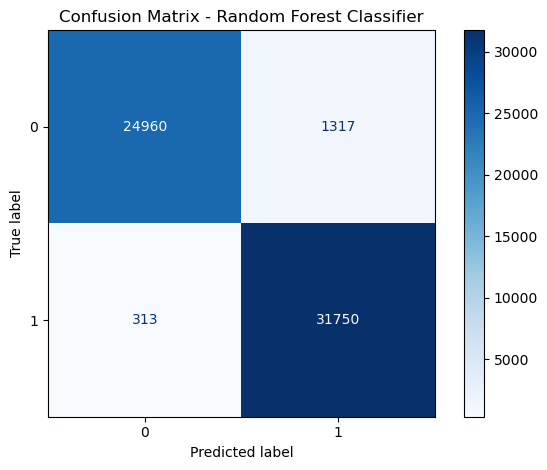

Accuracy: 97.21%
F1 Score: 97.20%


,precision,recall,f1-score,support
0,98.76,94.99,96.84,26277.00
1,96.02,99.02,97.50,32063.00
accuracy,97.21,97.21,97.21,0.97
macro avg,97.39,97.01,97.17,58340.00
weighted avg,97.25,97.21,97.20,58340.00


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
 
rf_baseline = RandomForestClassifier()
 
rf_baseline.fit(X_train, y_train)

y_pred_rf = rf_baseline.predict(X_test)
 
confusion_matrix_result(y_test, y_pred_rf, 'Random Forest Classifier')
report_result(y_test, y_pred_rf, "Random Forest - Baseline")

### <b>4.2. LGM Classifier - Baseline Model</b>

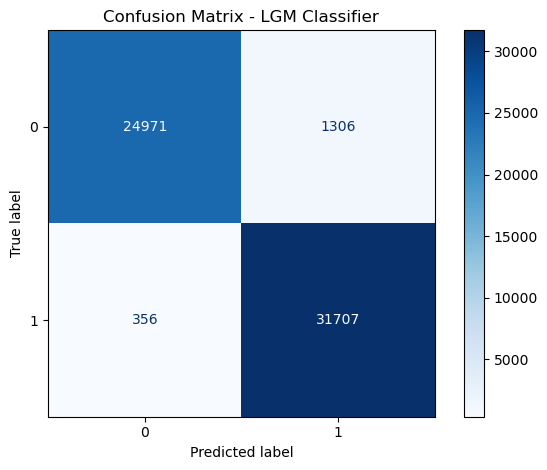

Accuracy: 97.15%
F1 Score: 97.15%


,precision,recall,f1-score,support
0,98.59,95.03,96.78,26277.00
1,96.04,98.89,97.45,32063.00
accuracy,97.15,97.15,97.15,0.97
macro avg,97.32,96.96,97.11,58340.00
weighted avg,97.19,97.15,97.15,58340.00


In [34]:
lgbm_baseline = LGBMClassifier(
    random_state=42,
    verbose= -1
)

lgbm_baseline.fit(X_train, y_train)
y_pred_lgbm = lgbm_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_lgbm, 'LGM Classifier')
report_result(y_test, y_pred_lgbm, "LGM - Baseline")

### <b>4.3. XGB Classifier - Baseline model</b>

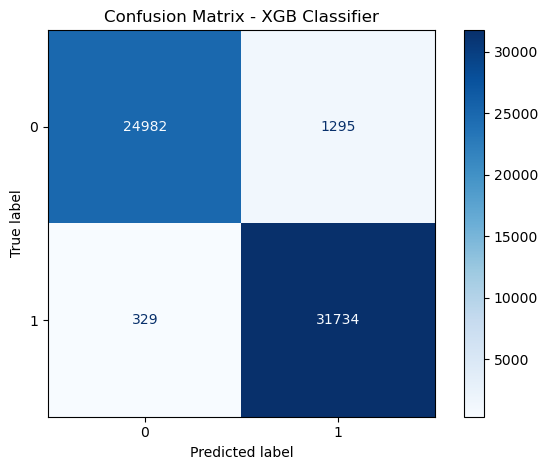

Accuracy: 97.22%
F1 Score: 97.21%


,precision,recall,f1-score,support
0,98.70,95.07,96.85,26277.00
1,96.08,98.97,97.51,32063.00
accuracy,97.22,97.22,97.22,0.97
macro avg,97.39,97.02,97.18,58340.00
weighted avg,97.26,97.22,97.21,58340.00


In [35]:
xgb_baseline = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_baseline.fit(X_train, y_train)
y_pred_xgb = xgb_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_xgb, 'XGB Classifier')
report_result(y_test, y_pred_xgb, "XGB - Baseline")

### <b>4.4. Bagging Classifier - Baseline model</b>

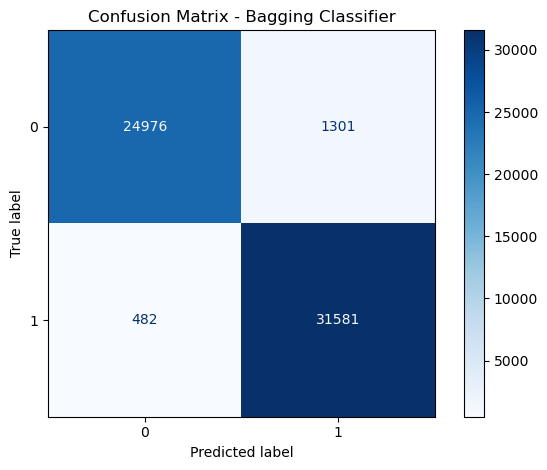

Accuracy: 96.94%
F1 Score: 96.94%


,precision,recall,f1-score,support
0,98.11,95.05,96.55,26277.00
1,96.04,98.50,97.25,32063.00
accuracy,96.94,96.94,96.94,0.97
macro avg,97.08,96.77,96.90,58340.00
weighted avg,96.97,96.94,96.94,58340.00


In [36]:
bagging_clf = BaggingClassifier(random_state=42)
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)

confusion_matrix_result(y_test, y_pred_bagging, 'Bagging Classifier')
report_result(y_test, y_pred_bagging, "Bagging - Baseline")

### <b>4.5. Extra Trees Classifier - Baseline model</b>

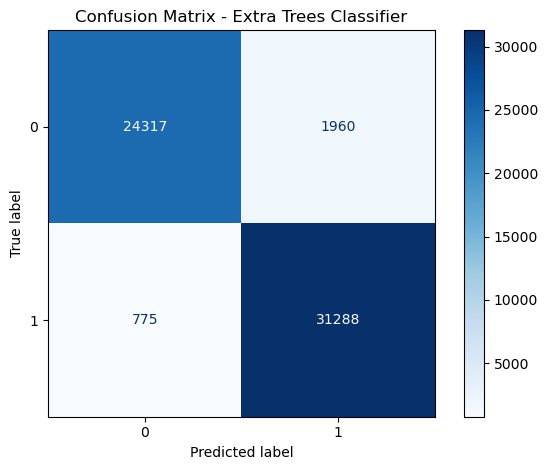

Accuracy: 95.31%
F1 Score: 95.30%


,precision,recall,f1-score,support
0,96.91,92.54,94.68,26277.00
1,94.10,97.58,95.81,32063.00
accuracy,95.31,95.31,95.31,0.95
macro avg,95.51,95.06,95.24,58340.00
weighted avg,95.37,95.31,95.30,58340.00


In [37]:
etc_baseline = ExtraTreesClassifier(random_state=42)
etc_baseline.fit(X_train, y_train)
y_pred_etc = etc_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_etc, 'Extra Trees Classifier')
report_result(y_test, y_pred_etc, "Extra Trees - Baseline")

### <b>4.6. Decision Tree Classifier - Baseline model</b>

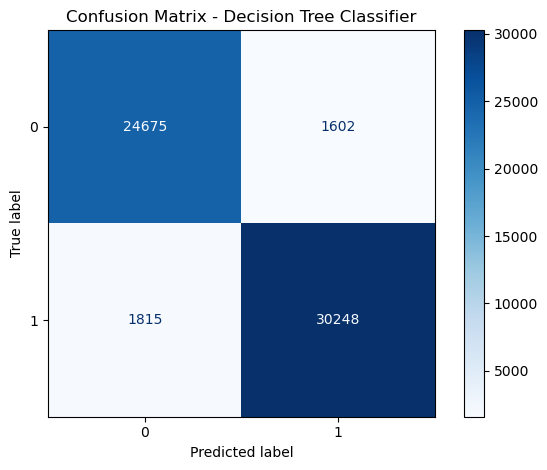

Accuracy: 94.14%
F1 Score: 94.15%


,precision,recall,f1-score,support
0,93.15,93.90,93.52,26277.00
1,94.97,94.34,94.65,32063.00
accuracy,94.14,94.14,94.14,0.94
macro avg,94.06,94.12,94.09,58340.00
weighted avg,94.15,94.14,94.15,58340.00


In [38]:

dtc_baseline = DecisionTreeClassifier(random_state=42)
dtc_baseline.fit(X_train, y_train)
y_pred_dtc = dtc_baseline.predict(X_test)

confusion_matrix_result(y_test, y_pred_dtc, 'Decision Tree Classifier')
report_result(y_test, y_pred_dtc, "Decision Tree - Baseline")

### <b> 5. Optimizovanje hiperparametara izabranih algoritama mašinskog učenja </b>

### 5.1 Random Forest Classifier 

In [40]:

param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

rf_base = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1
)

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params_rf = rf_random_search.best_params_

best_params_rf["CV F1 Score (%)"] = round(rf_random_search.best_score_ * 100, 2)

best_rf_df = pd.DataFrame([best_params_rf])
for col in best_rf_df.columns:
    if best_rf_df[col].dtype == float and best_rf_df[col].max() < 1:
        best_rf_df[col] = best_rf_df[col].round(3)

best_rf_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,CV F1 Score (%)
0,400,2,2,log2,10,None,97.60


In [41]:
#Evaluacija
best_rf = rf_random_search.best_estimator_
y_rf_pred_test = best_rf.predict(X_test)

report_result(y_test, y_rf_pred_test, "Random Forest - Optimized")

Accuracy: 97.23%
F1 Score: 97.22%


,precision,recall,f1-score,support
0,98.82,94.98,96.86,26277.00
1,96.02,99.07,97.52,32063.00
accuracy,97.23,97.23,97.23,0.97
macro avg,97.42,97.03,97.19,58340.00
weighted avg,97.28,97.23,97.22,58340.00


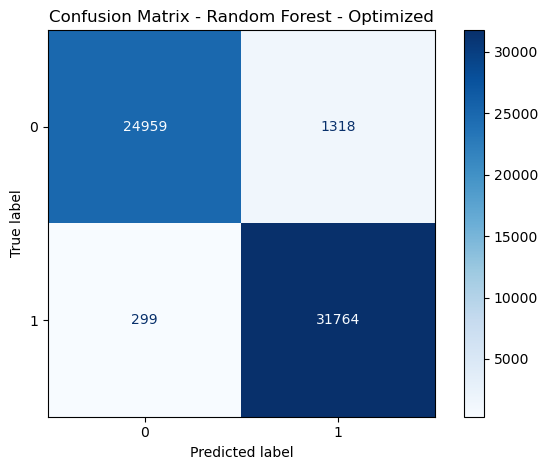

In [42]:
# Confusion Matrix
confusion_matrix_result(y_test, y_rf_pred_test, 'Random Forest - Optimized')

### 5.2 LGBM Classifier 


In [39]:
from lightgbm import LGBMClassifier

lgbm_param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [10, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.5, 1.0]
}

lgbm_base = LGBMClassifier(
    random_state=42,
    objective='binary',
    n_jobs=-1
)

cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lgbm_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params = lgbm_random_search.best_params_

best_params["CV F1 Score (%)"] = round(lgbm_random_search.best_score_ * 100, 2)

best_lgbm_df = pd.DataFrame([best_params])

for col in best_lgbm_df.columns:
    if best_lgbm_df[col].dtype == float and best_lgbm_df[col].max() < 1:
        best_lgbm_df[col] = best_lgbm_df[col].round(3)

best_lgbm_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,subsample,reg_lambda,reg_alpha,num_leaves,n_estimators,min_child_samples,max_depth,learning_rate,colsample_bytree,CV F1 Score (%)
0,1.00,0.50,0.00,31,200,30,-1,0.05,0.90,97.55


In [40]:
#Evaluacija
best_lgbm = lgbm_random_search.best_estimator_
y_lgbm_pred_test = best_lgbm.predict(X_test)

report_result(y_test, y_lgbm_pred_test, "LGBM - Optimized")

Accuracy: 97.16%
F1 Score: 97.15%


,precision,recall,f1-score,support
0,98.61,95.03,96.78,26277.00
1,96.04,98.90,97.45,32063.00
accuracy,97.16,97.16,97.16,0.97
macro avg,97.33,96.96,97.12,58340.00
weighted avg,97.20,97.16,97.15,58340.00


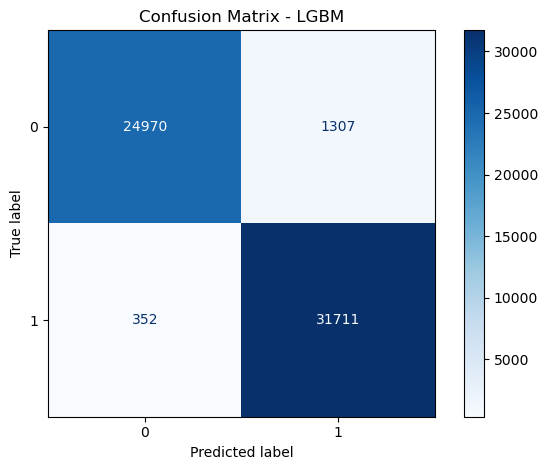

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_lgbm_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LGBM')
plt.tight_layout()
plt.show()

### 5.3 XGB Classifier

In [ ]:
xgb_base = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_param_dist = 
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]


xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params_xgb = xgb_random_search.best_params_

best_params_xgb["CV F1 Score (%)"] = round(xgb_random_search.best_score_ * 100, 2)

best_xgb_df = pd.DataFrame([best_params_xgb])
for col in best_xgb_df.columns:
    if best_xgb_df[col].dtype == float and best_xgb_df[col].max() < 1:
        best_xgb_df[col] = best_xgb_df[col].round(3)

best_xgb_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [47]:
#Evaluacija
best_xgb = xgb_random_search.best_estimator_
y_xgb_pred_test = best_xgb.predict(X_test)

report_result(y_test, y_xgb_pred_test, "XGB - Optimized")

Accuracy: 97.15%
F1 Score: 97.14%


,precision,recall,f1-score,support
0,98.74,94.88,96.77,26277.00
1,95.93,99.01,97.44,32063.00
accuracy,97.15,97.15,97.15,0.97
macro avg,97.33,96.94,97.11,58340.00
weighted avg,97.20,97.15,97.14,58340.00


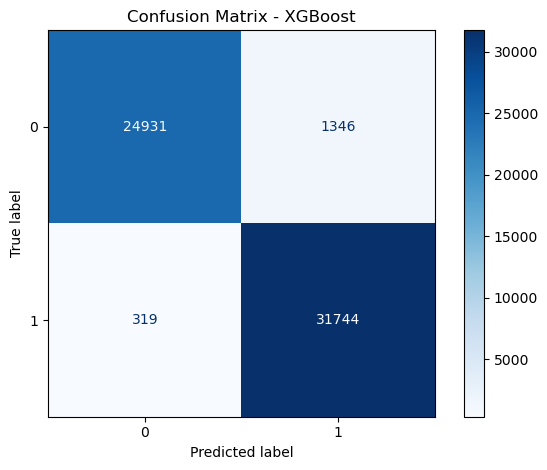

In [48]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_xgb_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 5.4 Bagging Classifier

In [49]:
bagging_base = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

bagging_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
bagging_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
bagging_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params_bagging = bagging_random_search.best_params_

best_params_bagging["CV F1 Score (%)"] = round(bagging_random_search.best_score_ * 100, 2)

best_bagging_df = pd.DataFrame([best_params_bagging])
for col in best_bagging_df.columns:
    if best_bagging_df[col].dtype == float and best_bagging_df[col].max() < 1:
        best_bagging_df[col] = best_bagging_df[col].round(3)

best_bagging_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,CV F1 Score (%)
0,1.00,1,0,300,1,5,0.05,0.30,0.70,97.54


In [50]:
#Evaluacija
best_bagging = bagging_random_search.best_estimator_
y_bagging_pred_test = best_bagging.predict(X_test)

report_result(y_test, y_bagging_pred_test, "Bagging - Optimized")

Accuracy: 97.15%
F1 Score: 97.14%


,precision,recall,f1-score,support
0,98.74,94.88,96.77,26277.00
1,95.93,99.01,97.44,32063.00
accuracy,97.15,97.15,97.15,0.97
macro avg,97.33,96.94,97.11,58340.00
weighted avg,97.20,97.15,97.14,58340.00


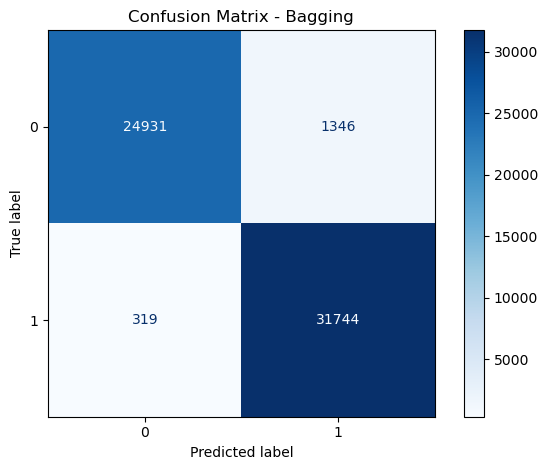

In [51]:
# Confusion Matrix
cm_bagging = confusion_matrix(y_test, y_bagging_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bagging)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Bagging')
plt.tight_layout()
plt.show()

### 5.5 Extra Trees Classifier

In [52]:
etc_base = ExtraTreesClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
etc_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

etc_random_search = RandomizedSearchCV(
    estimator=etc_base,
    param_distributions=etc_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
etc_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params_etc = etc_random_search.best_params_

best_params_etc["CV F1 Score (%)"] = round(etc_random_search.best_score_ * 100, 2)

best_etc_df = pd.DataFrame([best_params_etc])
for col in best_etc_df.columns:
    if best_etc_df[col].dtype == float and best_etc_df[col].max() < 1:
        best_etc_df[col] = best_etc_df[col].round(3)

best_etc_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,bootstrap,CV F1 Score (%)
0,100,5,4,None,None,None,False,97.55


In [53]:
#Evaluacija
best_etc = etc_random_search.best_estimator_
y_etc_pred_test = best_etc.predict(X_test)

report_result(y_test, y_etc_pred_test, "Extra Trees - Optimized")

Accuracy: 97.18%
F1 Score: 97.17%


,precision,recall,f1-score,support
0,98.75,94.93,96.80,26277.00
1,95.97,99.02,97.47,32063.00
accuracy,97.18,97.18,97.18,0.97
macro avg,97.36,96.97,97.14,58340.00
weighted avg,97.22,97.18,97.17,58340.00


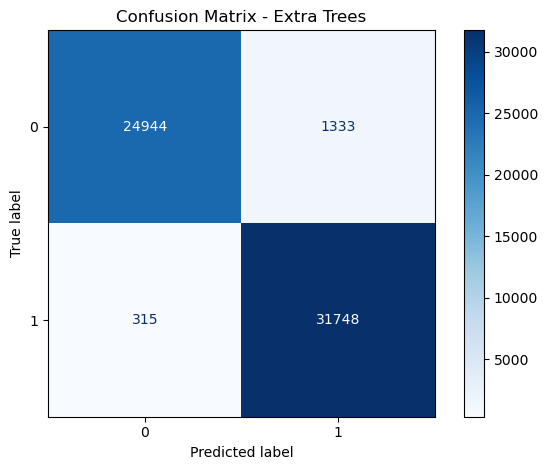

In [54]:
# Confusion Matrix
cm_etc = confusion_matrix(y_test, y_etc_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_etc)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Extra Trees')
plt.tight_layout()
plt.show()

### 5.6 Decision Trees Classifier

In [55]:
dt_base = DecisionTreeClassifier(
    random_state=42
)

dt_param_dist = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

dt_random_search = RandomizedSearchCV(
    estimator=dt_base,
    param_distributions=dt_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
dt_random_search.fit(X_train, y_train)

#Prikaz najboljih hiperparametara
best_params_dt = dt_random_search.best_params_

best_params_dt["CV F1 Score (%)"] = round(dt_random_search.best_score_ * 100, 2)

best_dt_df = pd.DataFrame([best_params_dt])
for col in best_dt_df.columns:
    if best_dt_df[col].dtype == float and best_dt_df[col].max() < 1:
        best_dt_df[col] = best_dt_df[col].round(3)

best_dt_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,class_weight,CV F1 Score (%)
0,5,1,None,10,gini,None,97.40


In [56]:
#Evaluacija
best_dt = dt_random_search.best_estimator_
y_dt_pred_test = best_dt.predict(X_test)

report_result(y_test, y_dt_pred_test, "Decision Tree - Optimized")

Accuracy: 97.04%
F1 Score: 97.03%


,precision,recall,f1-score,support
0,98.49,94.87,96.65,26277.00
1,95.92,98.81,97.34,32063.00
accuracy,97.04,97.04,97.04,0.97
macro avg,97.21,96.84,97.00,58340.00
weighted avg,97.08,97.04,97.03,58340.00


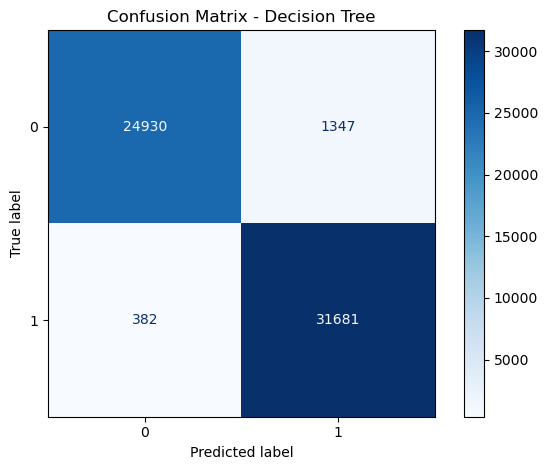

In [57]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_dt_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Decision Tree')
plt.tight_layout()
plt.show()

## <b> Poređenje rezultata modela </b>
 
U ovoj ćeliji se prikazuju svi rezultati baseline i optimizovanih modela za lakše poređenje.

In [58]:
column_order = [
    "Random Forest - Baseline", "Random Forest - Optimized",
    "LGM Classifier - Baseline", "LGBM - Optimized",
    "XGB - Baseline", "XGB - Optimized",
    "Bagging - Baseline", "Bagging - Optimized",
    "Extra Trees - Baseline", "Extra Trees - Optimized",
    "Decision Tree - Baseline", "Decision Tree - Optimized"
]

existing_columns = [col for col in column_order if col in result_df.columns]
result_df[existing_columns]

,Random Forest - Baseline,Random Forest - Optimized,LGBM - Optimized,XGB - Baseline,XGB - Optimized,Bagging - Baseline,Bagging - Optimized,Extra Trees - Baseline,Extra Trees - Optimized,Decision Tree - Baseline,Decision Tree - Optimized
Accuracy,97.21,97.23,97.17,97.14,97.15,96.97,97.15,95.34,97.18,94.33,97.04
Precision_0,98.76,98.82,98.73,98.73,98.74,98.20,98.74,97.08,98.75,93.45,98.49
Precision_1,96.02,96.02,95.98,95.93,95.93,96.03,95.93,94.03,95.97,95.06,95.92
Recall_0,94.99,94.98,94.94,94.88,94.88,95.03,94.88,92.43,94.93,94.01,94.87
Recall_1,99.02,99.07,99.00,99.00,99.01,98.57,99.01,97.72,99.02,94.60,98.81
F1-Score_0,96.84,96.86,96.80,96.77,96.77,96.59,96.77,94.70,96.80,93.73,96.65
F1-Score_1,97.50,97.52,97.47,97.44,97.44,97.28,97.44,95.84,97.47,94.83,97.34
F1-Score_Weighted,97.20,97.22,97.17,97.14,97.14,96.97,97.14,95.33,97.17,94.34,97.03


In [59]:
f1_score_df_rang = result_df.loc["F1-Score_Weighted"]

f1_score_df_rang = f1_score_df_rang.to_frame(name="F1-Score_Weighted")

f1_sorted = f1_score_df_rang.sort_values(by="F1-Score_Weighted", ascending=False)

print(f1_sorted)

                           F1-Score_Weighted
Random Forest - Optimized              97.22
Random Forest - Baseline               97.20
LGBM - Optimized                       97.17
Extra Trees - Optimized                97.17
LGM - Baseline                         97.16
XGB - Baseline                         97.14
Bagging - Optimized                    97.14
XGB - Optimized                        97.14
Decision Tree - Optimized              97.03
Bagging - Baseline                     96.97
Extra Trees - Baseline                 95.33
Decision Tree - Baseline               94.34


In [60]:
accuracy_df_rang = result_df.loc["Accuracy"]

accuracy_df_rang = accuracy_df_rang.to_frame(name="Accuracy")

accuracy_sorted = accuracy_df_rang.sort_values(by="Accuracy", ascending=False)

print(accuracy_sorted)

                           Accuracy
Random Forest - Optimized     97.23
Random Forest - Baseline      97.21
Extra Trees - Optimized       97.18
LGM - Baseline                97.17
LGBM - Optimized              97.17
XGB - Optimized               97.15
Bagging - Optimized           97.15
XGB - Baseline                97.14
Decision Tree - Optimized     97.04
Bagging - Baseline            96.97
Extra Trees - Baseline        95.34
Decision Tree - Baseline      94.33


In [61]:
# Sačuvaj sve najbolje modele u dictionary za kasniju upotrebu (LIME, SHAP, itd.)
models_for_lime = {
    'LGBM': best_lgbm,
    'Random Forest': best_rf,
    'XGB': best_xgb,
    'Bagging': best_bagging,
    'Extra Trees': best_etc,
    'Decision Tree': best_dt
}
 
print("Svi modeli su sačuvani u 'models_for_lime' dictionary!")
print(f"Dostupni modeli: {list(models_for_lime.keys())}")

Svi modeli su sačuvani u 'models_for_lime' dictionary!
Dostupni modeli: ['LGBM', 'Random Forest', 'XGB', 'Bagging', 'Extra Trees', 'Decision Tree']


### <b> 6. Detaljna analiza interpretabilnosti dobijenih modela  mašinskog učenja </b>

#### 6.1. Feature Importance

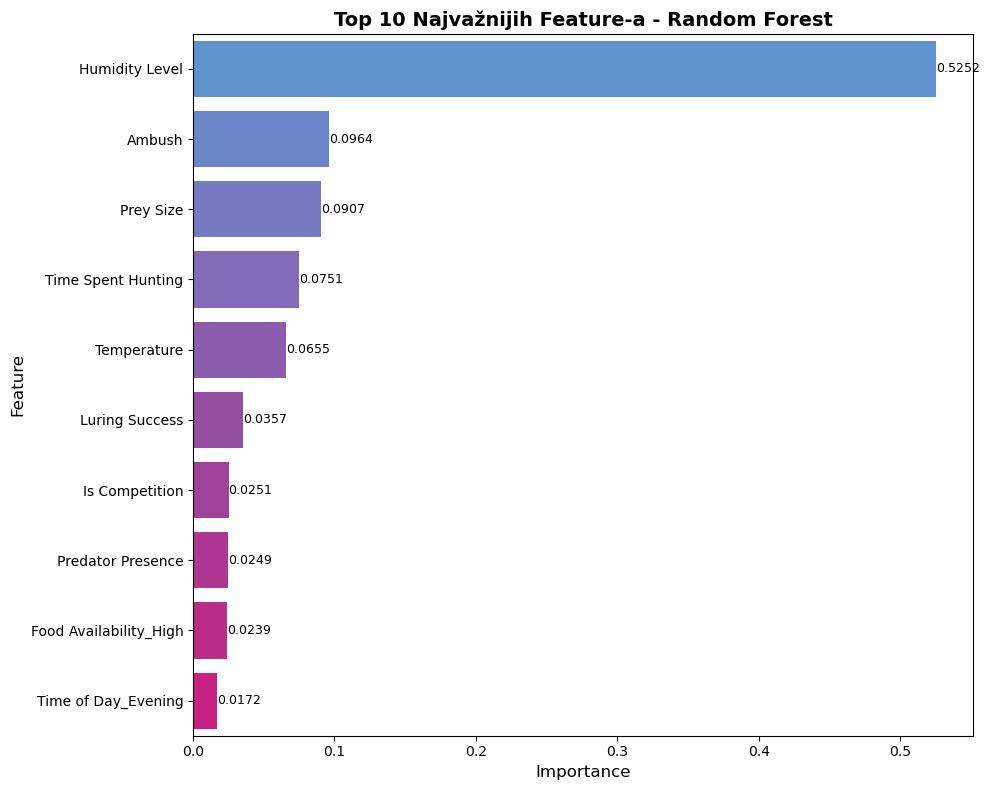

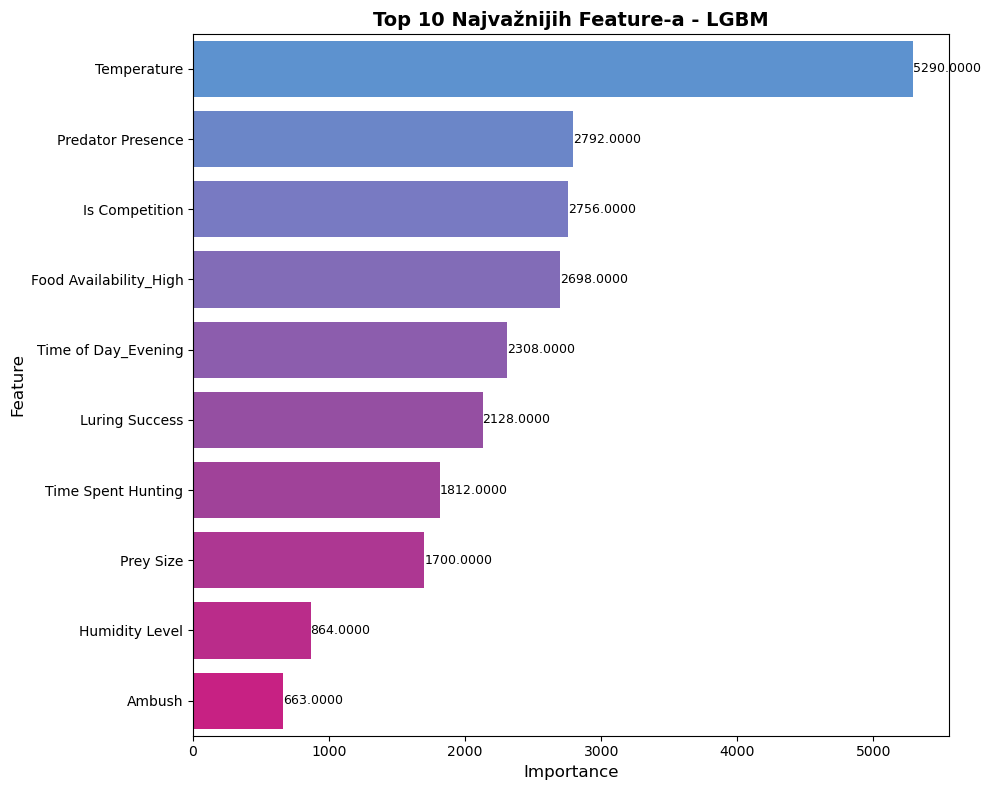

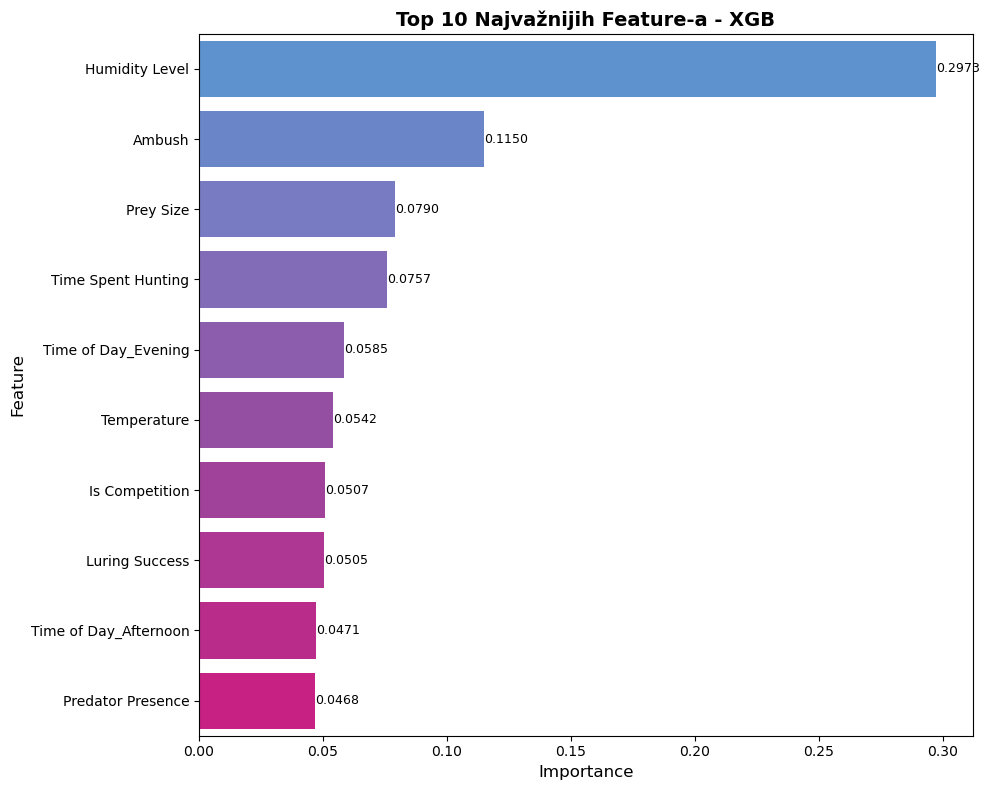

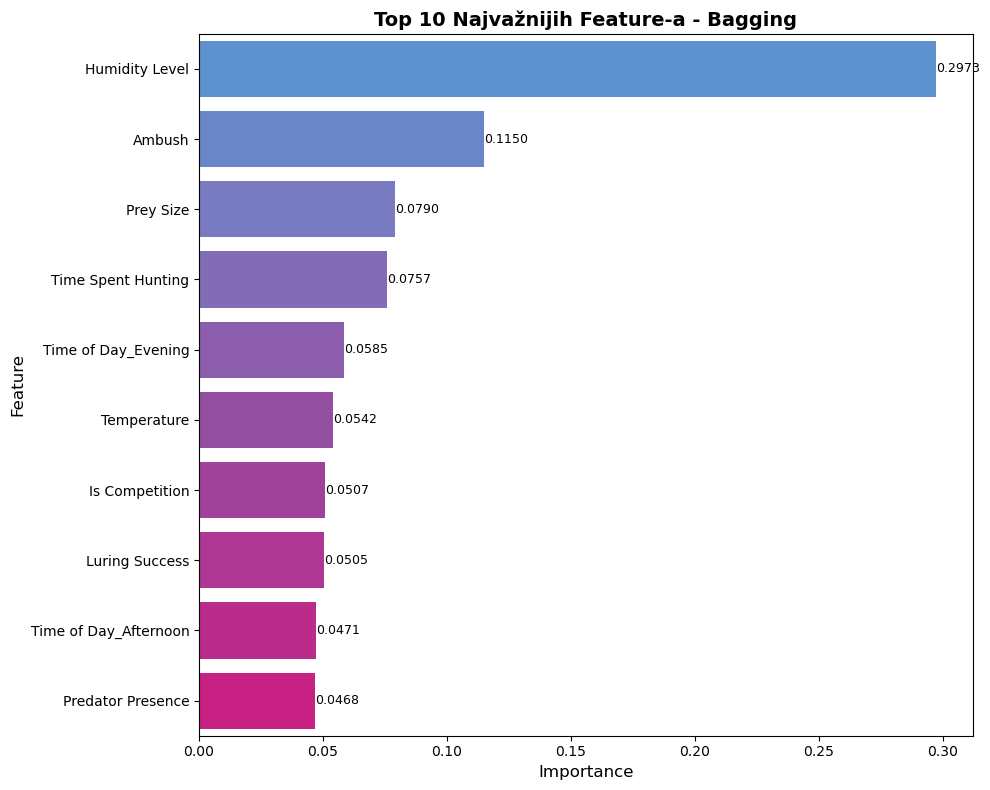

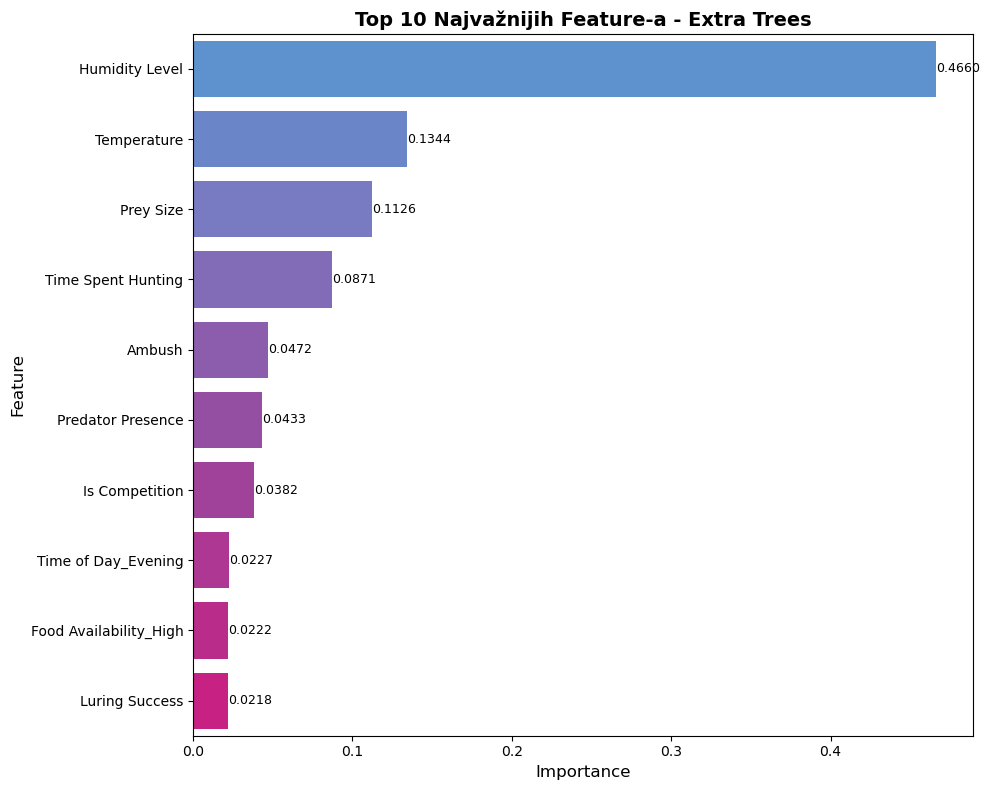

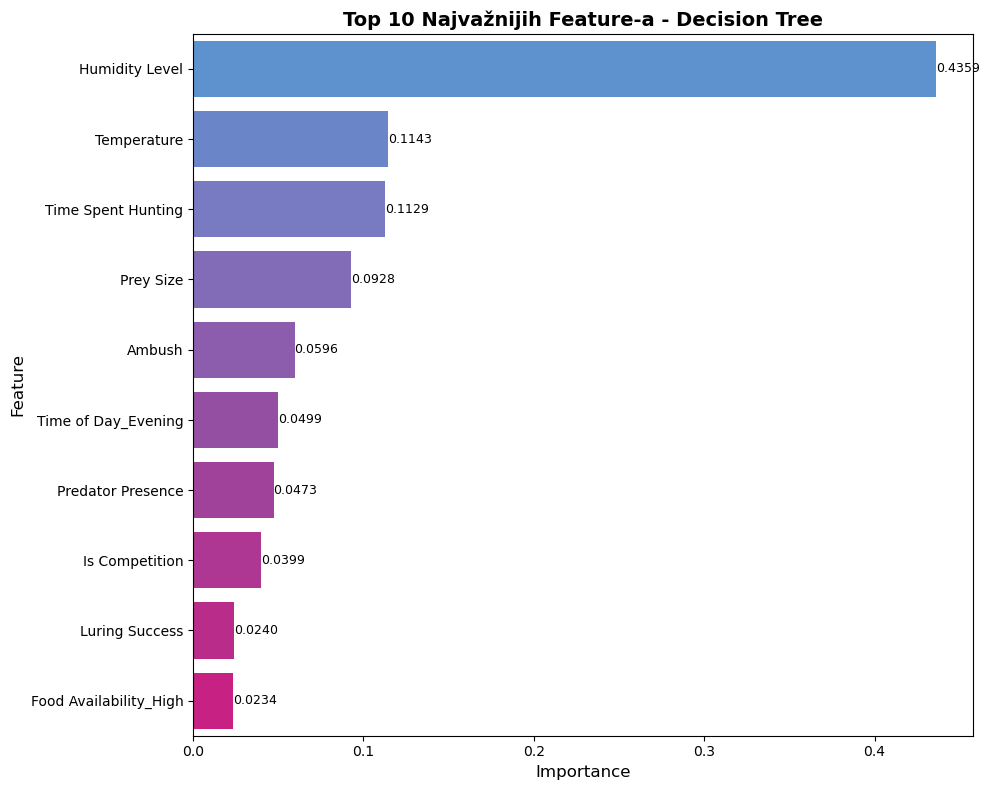

In [62]:
def plot_feature_importance(model, model_name, feature_names, top_n=10):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=feature_importance,
        y='Feature',
        x='Importance',
        palette=custom_palette
    )
    
    for i, (idx, row) in enumerate(feature_importance.iterrows()):
        ax.text(row['Importance'], i, f'{row["Importance"]:.4f}',
                va='center', ha='left', fontsize=9)
    
    plt.title(f'Top {top_n} Najvažnijih Feature-a - {model_name}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
 
custom_palette = sns.color_palette(['#4A90E2', '#5B7FD8', '#6C6ECE', '#7D5FC4',
                                     '#8E50BA', '#9F41B0', '#B032A6', '#C1239C',
                                     '#D21492', '#E30588'])
 
models = {
    'Random Forest': best_rf,
    'LGBM': best_lgbm,
    'XGB': best_xgb,
    'Bagging': best_bagging,
    'Extra Trees': best_etc,
    'Decision Tree': best_dt
}
 
for model_name, model in models.items():
    plot_feature_importance(model, model_name, X_train.columns)

### 6.2 LIME

In [64]:
import warnings
warnings.filterwarnings('ignore')
 
explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Neuspešan lov', 'Uspešan lov'],
    mode='classification',
    training_labels=y_train.values,
    discretize_continuous=True
)
 
def get_lime_explanation_list(explanation, top_n=10):
    available_labels = list(explanation.available_labels())
    if len(available_labels) > 0:
        label = available_labels[0]
        exp_list = explanation.as_list(label=label)
    else:
        try:
            exp_list = explanation.as_list()
        except:
            exp_list = explanation.as_list(label=0)
    
    exp_list_sorted = sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)[:top_n]
    return exp_list_sorted
 
print("LIME explainer inicijalizovan i funkcije definisane.")

LIME explainer inicijalizovan i funkcije definisane.


In [70]:
# LIME - Prikupljanje podataka za sve primere
pred_rows = []
lime_rows = []
 
# Primer 1: Uspešan lov
successful_indices = np.where(y_test.values == 1)[0]
if len(successful_indices) > 0:
    instance_idx_1 = successful_indices[0]
    instance_1 = X_test.iloc[instance_idx_1].values
    actual_class_1 = int(y_test.iloc[instance_idx_1])
    
    for model_name, model in models_for_lime.items():
        prediction = model.predict_proba(instance_1.reshape(1, -1))[0]
        p_success = prediction[1]
        p_fail = prediction[0]
        
        pred_rows.append((1, actual_class_1, model_name, p_success, p_fail))
        
        explanation = explainer.explain_instance(
            instance_1,
            model.predict_proba,
            num_features=len(X_train.columns),
            top_labels=1
        )
        
        exp_list = get_lime_explanation_list(explanation, top_n=10)
        for feature, weight in exp_list:
            lime_rows.append((1, model_name, feature, weight))
 
unsuccessful_indices = np.where(y_test.values == 0)[0]
if len(unsuccessful_indices) > 0:
    instance_idx_2 = unsuccessful_indices[0]
    instance_2 = X_test.iloc[instance_idx_2].values
    actual_class_2 = int(y_test.iloc[instance_idx_2])
    
    for model_name, model in models_for_lime.items():
        prediction = model.predict_proba(instance_2.reshape(1, -1))[0]
        p_success = prediction[1]
        p_fail = prediction[0]
        
        pred_rows.append((2, actual_class_2, model_name, p_success, p_fail))
        
        # Generisanje LIME objašnjenja
        explanation = explainer.explain_instance(
            instance_2,
            model.predict_proba,
            num_features=len(X_train.columns),
            top_labels=1
        )
        
        exp_list = get_lime_explanation_list(explanation, top_n=10)
        for feature, weight in exp_list:
            lime_rows.append((2, model_name, feature, weight))
 
# Primer 3: Granični slučaj
proba_predictions = best_lgbm.predict_proba(X_test)
uncertain_indices = np.where(np.abs(proba_predictions[:, 1] - 0.5) < 0.1)[0]
 
if len(uncertain_indices) > 0:
    instance_idx_3 = uncertain_indices[0]
    instance_3 = X_test.iloc[instance_idx_3].values
    actual_class_3 = int(y_test.iloc[instance_idx_3])
    
    for model_name, model in models_for_lime.items():
        prediction = model.predict_proba(instance_3.reshape(1, -1))[0]
        p_success = prediction[1]
        p_fail = prediction[0]
        
        pred_rows.append((3, actual_class_3, model_name, p_success, p_fail))
        
        # Generisanje LIME objašnjenja
        explanation = explainer.explain_instance(
            instance_3,
            model.predict_proba,
            num_features=len(X_train.columns),
            top_labels=1
        )
        
        exp_list = get_lime_explanation_list(explanation, top_n=10)
        for feature, weight in exp_list:
            lime_rows.append((3, model_name, feature, weight))
 
# Kreiranje DataFrame-ova
df_pred = pd.DataFrame(pred_rows, columns=["Primer", "TrueLabel", "Model", "P_success", "P_fail"])
df_lime = pd.DataFrame(lime_rows, columns=["Primer", "Model", "Feature", "Weight"])
 
# Dodaj predikciju klase i da li je pogodio
df_pred["PredLabel"] = (df_pred["P_success"] >= 0.5).astype(int)
df_pred["Pogođeno"] = (df_pred["PredLabel"] == df_pred["TrueLabel"])
 
label_map = {0: "Neuspešan (0)", 1: "Uspešan (1)"}
df_pred["Očekivano"] = df_pred["TrueLabel"].map(label_map)
df_pred["Predikcija"] = df_pred["PredLabel"].map(label_map)
 
def show_predictions_table(example_id: int):
    """Prikazuje tabelu predikcija za dati primer sa stilizovanim formatom"""
    view = (df_pred[df_pred["Primer"] == example_id]
            .sort_values("P_success", ascending=False)
            .copy())
 
    view["Uspeh (%)"] = (view["P_success"] * 100).round(2)
    view["Neuspeh (%)"] = (view["P_fail"] * 100).round(2)
 
    cols = ["Model", "Očekivano", "Predikcija", "Uspeh (%)", "Neuspeh (%)", "Pogođeno"]
    
    # Funkcija za bojenje Pogođeno kolone
    def color_correct(val):
        if val:
            return 'background-color: rgba(0, 200, 0, 0.2); color: green; font-weight: bold'  # Svetlo zeleno za tačne
        else:
            return 'background-color: rgba(200, 0, 0, 0.2); color: red; font-weight: bold'  # Svetlo crveno za netačne
    
    # Funkcija za bojenje celih redova na osnovu tačnosti
    def highlight_rows(row):
        if row['Pogođeno']:
            return ['background-color: rgba(0, 255, 0, 0.05)' for _ in row]  # Veoma svetlo zeleno za tačne redove
        else:
            return ['background-color: rgba(255, 0, 0, 0.05)' for _ in row]  # Veoma svetlo crveno za netačne redove
    
    # Bez bar-ova - čista tabela sa podacima, vizuelizacije su u grafovima
    sty = (view[cols]
           .style
           .format({"Uspeh (%)": "{:.2f}%", "Neuspeh (%)": "{:.2f}%"})
           .applymap(color_correct, subset=["Pogođeno"])
           .apply(highlight_rows, axis=1)
          )
    return sty
 
def show_lime_table_all_models(example_id: int, topn: int = 10):
    """Prikazuje LIME tabelu za dati primer sa kolonama za sve modele"""
    view = df_lime[df_lime["Primer"] == example_id].copy()
    
    # Pivot tabela: Feature vs Model
    pivot = view.pivot_table(index="Feature", columns="Model", values="Weight", aggfunc="mean")
    
    # Dodaj kolonu sa prosečnom apsolutnom vrednošću za sortiranje
    pivot["Avg_Abs"] = pivot.abs().mean(axis=1)
    pivot = pivot.sort_values("Avg_Abs", ascending=False).head(topn)
    pivot = pivot.drop("Avg_Abs", axis=1)
    
    # Funkcija za bojenje na osnovu znaka
    def color_weights(val):
        if pd.isna(val):
            return ''
        if val > 0:
            return 'background-color: rgba(0, 255, 0, 0.3)'  # Svetlo zeleno za pozitivne
        elif val < 0:
            return 'background-color: rgba(255, 0, 0, 0.3)'  # Svetlo crveno za negativne
        else:
            return ''
    
    # Formatiraj sve kolone modela
    format_dict = {col: "{:+.2f}" for col in pivot.columns}
    
    sty = (pivot
           .style
           .format(format_dict)
           .applymap(color_weights)
          )
    return sty
 
def show_example_features(example_id: int):
    """Prikazuje vrednosti feature-a za dati primer (horizontalno)"""
    # Pronađi indeks primera na osnovu example_id
    if example_id == 1:
        successful_indices = np.where(y_test.values == 1)[0]
        if len(successful_indices) > 0:
            idx = successful_indices[0]
    elif example_id == 2:
        unsuccessful_indices = np.where(y_test.values == 0)[0]
        if len(unsuccessful_indices) > 0:
            idx = unsuccessful_indices[0]
    elif example_id == 3:
        proba_predictions = best_lgbm.predict_proba(X_test)
        uncertain_indices = np.where(np.abs(proba_predictions[:, 1] - 0.5) < 0.1)[0]
        if len(uncertain_indices) > 0:
            idx = uncertain_indices[0]
    
    # Prikaz vrednosti feature-a
    example_data = X_test.iloc[idx]
    actual_class = y_test.iloc[idx]
    
    print(f"\nVrednosti feature-a za ovaj primer:")
    
    # Kreiraj horizontalnu DataFrame tabelu (feature-i kao kolone)
    feature_df = pd.DataFrame([example_data.values], columns=example_data.index)
    
    return feature_df.style.format("{:.2f}").set_properties(**{'text-align': 'center'})
 
print("DataFrame-ovi kreirani. Funkcije za prikaz definisane.")

DataFrame-ovi kreirani. Funkcije za prikaz definisane.


In [71]:
primeri = {
    1: "Uspešan lov",
    2: "Neuspešan lov",
    3: "Granični slučaj"
}
 
for primer_id, opis in primeri.items():
    try:
        print("="*80)
        print(f"PRIMER {primer_id}: {opis}")
        print("="*80)
        
        display(show_example_features(primer_id))
        print("\nPredikcije modela:")
        display(show_predictions_table(primer_id))
        print("\nLIME objašnjenja (svi modeli):")
        display(show_lime_table_all_models(primer_id))
        print("\n" * 2)
        
    except Exception as e:
        print(f"Greška pri prikazu primera {primer_id}: {str(e)}")
        continue

PRIMER 1: Uspešan lov

Vrednosti feature-a za ovaj primer:


,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Food Availability_High,Food Availability_Low,Food Availability_Medium
0,0.70,34.64,1.00,2.98,2.99,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00



Predikcije modela:


,Model,Očekivano,Predikcija,Uspeh (%),Neuspeh (%),Pogođeno
4,Extra Trees,Uspešan (1),Uspešan (1),99.67%,0.33%,True
5,Decision Tree,Uspešan (1),Uspešan (1),98.02%,1.98%,True
3,Bagging,Uspešan (1),Uspešan (1),97.61%,2.39%,True
2,XGB,Uspešan (1),Uspešan (1),97.61%,2.39%,True
0,LGBM,Uspešan (1),Uspešan (1),94.29%,5.71%,True
1,Random Forest,Uspešan (1),Uspešan (1),81.41%,18.59%,True



LIME objašnjenja (svi modeli):


Model,Bagging,Decision Tree,Extra Trees,LGBM,Random Forest,XGB
Feature,,,,,,
0.60 < Humidity Level <= 0.75,+0.36,+0.33,+0.33,+0.32,+0.22,+0.33
Ambush <= 0.00,-0.16,-0.15,-0.16,-0.16,-0.17,-0.17
Prey Size <= 3.32,-0.11,-0.10,-0.12,-0.11,-0.09,-0.09
0.00 < Luring Success <= 1.00,+0.11,+0.09,+0.11,+0.09,+0.10,+0.10
Food Availability_High <= 0.00,-0.10,-0.10,-0.09,-0.08,-0.08,-0.10
0.00 < Time of Day_Evening <= 1.00,-0.09,-0.07,-0.08,-0.07,-0.06,-0.07
0.00 < Is Competition <= 1.00,-0.06,-0.08,-0.07,-0.06,-0.05,-0.06
Predator Presence <= 0.00,+0.07,+0.06,+0.09,+0.05,+0.04,+0.05
Temperature > 31.25,-0.05,-0.06,-0.06,-0.06,-0.04,-0.07





PRIMER 2: Neuspešan lov

Vrednosti feature-a za ovaj primer:


,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Food Availability_High,Food Availability_Low,Food Availability_Medium
0,0.89,25.13,0.00,3.15,3.38,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00



Predikcije modela:


,Model,Očekivano,Predikcija,Uspeh (%),Neuspeh (%),Pogođeno
7,Random Forest,Neuspešan (0),Neuspešan (0),13.56%,86.44%,True
6,LGBM,Neuspešan (0),Neuspešan (0),4.35%,95.65%,True
8,XGB,Neuspešan (0),Neuspešan (0),0.51%,99.49%,True
9,Bagging,Neuspešan (0),Neuspešan (0),0.51%,99.49%,True
10,Extra Trees,Neuspešan (0),Neuspešan (0),0.00%,100.00%,True
11,Decision Tree,Neuspešan (0),Neuspešan (0),0.00%,100.00%,True



LIME objašnjenja (svi modeli):


Model,Bagging,Decision Tree,Extra Trees,LGBM,Random Forest,XGB
Feature,,,,,,
Humidity Level > 0.75,+0.35,+0.34,+0.34,+0.32,+0.24,+0.36
Ambush <= 0.00,+0.18,+0.17,+0.19,+0.17,+0.16,+0.16
Luring Success <= 0.00,+0.11,+0.09,+0.11,+0.11,+0.08,+0.13
Food Availability_High <= 0.00,+0.07,+0.12,+0.08,+0.10,+0.07,+0.09
3.32 < Prey Size <= 5.60,+0.10,+0.06,+0.09,+0.06,+0.06,+0.11
Time of Day_Evening <= 0.00,-0.09,-0.05,-0.10,-0.07,-0.04,-0.06
23.74 < Temperature <= 27.48,-0.06,-0.08,-0.06,-0.06,-0.05,-0.07
2.70 < Time Spent Hunting <= 3.84,-0.07,-0.06,-0.04,-0.04,-0.06,-0.06
0.00 < Predator Presence <= 1.00,+0.05,+0.05,+0.04,+0.06,+0.06,+0.06





PRIMER 3: Granični slučaj

Vrednosti feature-a za ovaj primer:


,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Food Availability_High,Food Availability_Low,Food Availability_Medium
0,0.37,24.99,1.00,4.81,7.54,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00



Predikcije modela:


,Model,Očekivano,Predikcija,Uspeh (%),Neuspeh (%),Pogođeno
12,LGBM,Neuspešan (0),Uspešan (1),59.09%,40.91%,False
13,Random Forest,Neuspešan (0),Neuspešan (0),45.02%,54.98%,True
14,XGB,Neuspešan (0),Neuspešan (0),40.34%,59.66%,True
15,Bagging,Neuspešan (0),Neuspešan (0),40.34%,59.66%,True
16,Extra Trees,Neuspešan (0),Neuspešan (0),22.50%,77.50%,True
17,Decision Tree,Neuspešan (0),Neuspešan (0),1.00%,99.00%,True



LIME objašnjenja (svi modeli):


Model,Bagging,Decision Tree,Extra Trees,LGBM,Random Forest,XGB
Feature,,,,,,
Humidity Level <= 0.45,+0.34,+0.34,+0.35,-0.31,+0.24,+0.32
Ambush <= 0.00,+0.19,+0.16,+0.18,-0.16,+0.17,+0.17
0.00 < Luring Success <= 1.00,-0.11,-0.12,-0.09,+0.12,-0.09,-0.14
Food Availability_High <= 0.00,+0.07,+0.10,+0.09,-0.10,+0.07,+0.08
5.60 < Prey Size <= 7.88,-0.09,-0.09,-0.09,+0.08,-0.07,-0.07
Time of Day_Evening <= 0.00,-0.10,-0.07,-0.07,+0.07,-0.06,-0.09
23.74 < Temperature <= 27.48,-0.07,-0.09,-0.07,+0.08,-0.05,-0.07
Is Competition <= 0.00,-0.07,-0.09,-0.06,+0.05,-0.05,-0.07
Time Spent Hunting > 3.84,-0.04,-0.09,-0.06,+0.07,-0.05,-0.06


Primer,1,2,3
Model,,,
Bagging,97.61%,0.51%,40.34%
Decision Tree,98.02%,0.00%,1.00%
Extra Trees,99.67%,0.00%,22.50%
LGBM,94.29%,4.35%,59.09%
Random Forest,81.41%,13.56%,45.02%
XGB,97.61%,0.51%,40.34%


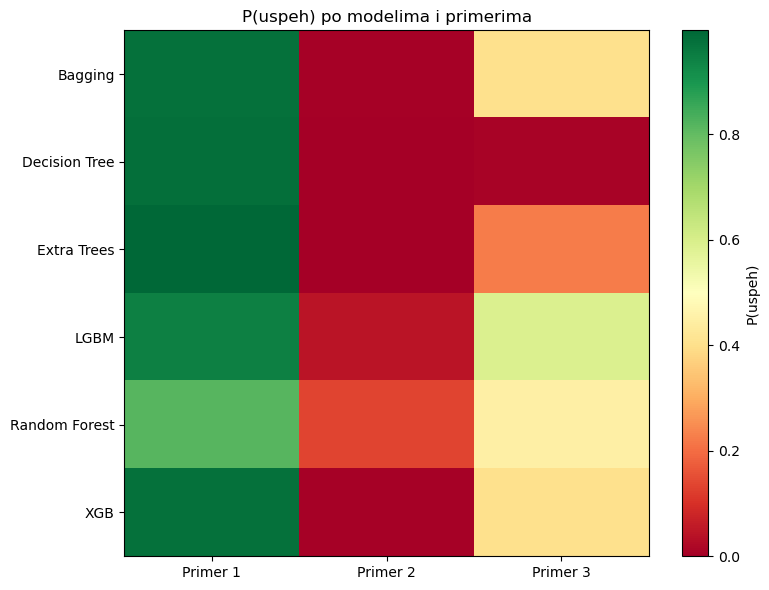

In [72]:
pivot = df_pred.pivot_table(index="Model", columns="Primer", values="P_success", aggfunc="mean")
 
display(pivot.style.format("{:.2%}").background_gradient(axis=None))
 
plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto", cmap='RdYlGn')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), [f"Primer {c}" for c in pivot.columns])
plt.title("P(uspeh) po modelima i primerima")
plt.colorbar(label="P(uspeh)")
plt.tight_layout()
plt.show()

### 6.3 SHAP